# 0 . Intro to Colab

You can treat Colab as a cloud version of python notebook, that can directly read, run, save data on your Google instead of on your personal laptop.



Apart from regular notebook features, several useful tips:

1. Every time you re-open colab, or your internet falls off and you need to reconnect, it wipes out all the data and files you loaded. Thus you need to re-run all of them, including loading packages and git clone.

2. It can run bash commands directly, i.e. you can clone git repo in the code cell. See example in Section 1.

3. On the left vertical menu, the top icon with 3 bullet points and 3 lines is Table of content. It can be really efficient in navigating to different sections

4. Folder tips: Also on the left, the lowest folder icon. Check if you have all the folders you need under the folder icon. The home folder is /content/. Everything you download is here by default. Everything got wiped out if you reconnect. There is one folder that is permanent called /content/sample_data. It is a colab default folder for some tutoring purposes.

5. Find path to load file: click folder icon on the left, it will show all of your current folders, go to the one you want to load, on the right click the 3 dots, select copy path.

More info can be found here: https://research.google.com/colaboratory/faq.html


# 1 .Import packages

Install the statistical packages needed

In [ ]:
! pip install scikit-gstat
! pip install gstatsim

In [ ]:
! pip install netCDF4

In [ ]:
! pip install networkx

Clone the github repo I created for the project. You should all have access to it.

In [ ]:
! git clone https://github.com/EmmaLammE/GP258_radar_project.git
%cd /content/
! cp /content/GP258_radar_project/plot_utils.py .

In [ ]:
%cd /content/GP258_radar_project/
! git pull

In [5]:
import numpy as np
import pandas as pd
from scipy import special
from scipy import stats
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
# import gstatsim as gs
from statsmodels.graphics.gofplots import qqplot
import netCDF4
import warnings
import networkx as nx


import scipy.io
# import skgstat as skg
# from skgstat import models
import matplotlib.pyplot as plt
from IPython.display import Image
import random
from plot_utils import make_colorbar, splot2D, mplot2_std,mplot1
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LightSource
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Self defined functions

Define your functions below

In [6]:
def find_shortest_path_backup(data, start_row, end_row, mask = None, mask_trace_low = None, mask_trace_high = None, plot_on = True, title = None):

  ## Finds the shortest path across the image, using edge weights
  ## that are inversely proportional to the image.

	## To automatically search for starting and ending rows, pass
	## in start_row = None and end_row = None.

  ## Otherwise, pass in the data matrix,
  ## and give the starting and ending row indices.

	n_rows, n_cols = data.shape
	nz = n_rows*n_cols
	data_copy = np.copy(data)

	if mask is not None:
		data[0:mask,:] = 0.0 ## Mask out the first "mask" rows, to remove surface reflectors

	if mask_trace_low is not None:
		for j in range(len(mask_trace_low)):
			data[mask_trace_low[j]::,j] = 0.0

	if mask_trace_high is not None:
		for j in range(len(mask_trace_high)):
			data[0:mask_trace_high[j],j] = 0.0

	## Create edges
	edges = []
	for i in range(0, n_cols):
		for j in range(0, n_rows):

			if j == 0:
				j_ind = np.array([0,1])
			elif j == (n_rows - 1):
				j_ind = np.array([-1, 0])
			else:
				j_ind = np.array([-1,0,1])

			if i == 0:
				ind_self = i + j*n_cols*np.ones(len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])

			elif i == (n_cols - 1):
				ind_self = i + j*n_cols*np.ones(len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent = np.array([(i - 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])

			else:
				ind_self = i + j*n_cols*np.ones(2*len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent1 = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])
				ind_adjacent2 = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])
				ind_adjacent = np.concatenate((ind_adjacent1, ind_adjacent2), axis = 0)

			edges.append(np.concatenate((ind_adjacent.reshape(1,-1), ind_self.reshape(1,-1))))

	edges = np.hstack(edges).astype('int') ## Edge weights assumed to be inversely proportional to coherency.
	weights = data.max() - 0.5*(data.reshape(-1)[edges[0]] + data.reshape(-1)[edges[1]])
	edges = np.concatenate((edges.T, weights[:,None]), axis = 1)

	G = nx.Graph()
	G.add_weighted_edges_from(edges) # weight = weights)

	if (start_row is not None)*(end_row is not None):

		source_node = start_row*n_cols
		target_node = end_row*n_cols + (n_cols - 1)

		path = np.array(nx.shortest_path(G, source = source_node, target = target_node, weight = 'weight')).astype('int')

	else:

		source_nodes = np.arange(n_rows)*n_cols
		target_nodes = np.arange(n_rows)*n_cols + (n_cols - 1)

		tree = cKDTree(target_nodes[:,None])

		L_min = np.inf
		for i in range(len(source_nodes)):

			result = nx.single_source_dijkstra(G, source_nodes[i], weight = 'weight')
			path_lens = np.array([result[0][j] for j in range(len(result[0]))])
			path_ends = np.array([result[1][j][-1] for j in range(len(result[0]))]).astype('int')
			ip = np.where(tree.query(path_ends[:,None])[0] == 0)[0]

			imin = np.argmin(path_lens[ip])

			if path_lens[ip[imin]] < L_min:
				L_min = path_lens[ip[imin]]
				path = np.array(result[1][ip[imin]]).astype('int')

			print('%d %0.4f'%(i, L_min))

	irows = np.floor(path/n_cols).astype('int')
	icols = path - irows*n_cols

	if plot_on == True:
		fig, ax = plt.subplots(1, figsize = [16,20])
		ax.imshow(data_copy, aspect = 0.75)
		ax.set_xlabel('Along flow index')
		ax.set_ylabel('Depth index')
		if title is not None:
			ax.set_title(title)

		fig, ax = plt.subplots(1, figsize = [16,20])
		ax.imshow(data_copy, aspect = 0.75)
		ax.scatter(icols, irows, c = 'r', s = 2, alpha = 0.5)
		ax.set_xlabel('Along flow index')
		ax.set_ylabel('Depth index')
		if title is not None:
			ax.set_title(title)

		plt.show(block = False)

	return irows, icols

In [7]:
def find_shortest_path_backup_ver_2(data, start_row, end_row, mask = None, mask_trace_low = None, mask_trace_high = None, plot_on = True, ind_slice = None, ind_slice_horiz = None, weight_horizontals = None, zoom = None, title = None, save = False):

  ## Finds the shortest path across the image, using edge weights
  ## that are inversely proportional to the image.

	## To automatically search for starting and ending rows, pass
	## in start_row = None and end_row = None.

  ## Otherwise, pass in the data matrix,
  ## and give the starting and ending row indices.

	data_copy = np.copy(data)

	if ind_slice is not None:

		data = data[ind_slice,:]
		start_row = start_row - ind_slice[0]
		end_row = end_row - ind_slice[0]

		if mask_trace_low is not None:
			mask_trace_low = mask_trace_low - ind_slice[0]

		if mask_trace_high is not None:
			mask_trace_high = mask_trace_high - ind_slice[0]


	if ind_slice_horiz is not None:

		data = data[:,ind_slice_horiz]

	n_rows, n_cols = data.shape
	nz = n_rows*n_cols

	if mask is not None:
		data[0:mask,:] = 0.0 ## Mask out the first "mask" rows, to remove surface reflectors

	if mask_trace_low is not None:
		for j in range(len(mask_trace_low)):
			if (np.isnan(mask_trace_low[j]) != 1) + (mask_trace_low[j] > 0):
				data[mask_trace_low[j]::,j] = 0.0

	if mask_trace_high is not None:
		for j in range(len(mask_trace_high)):
			if (np.isnan(mask_trace_high[j]) != 1) + (mask_trace_high[j] > 0):
				# print(j)
				data[0:mask_trace_high[j],j] = 0.0

	# plt.figure()
	# plt.imshow(data)
	# plt.show()
	# moi

	## Create edges
	edges = []
	for i in range(0, n_cols):
		for j in range(0, n_rows):

			if j == 0:
				j_ind = np.array([0,1])
			elif j == (n_rows - 1):
				j_ind = np.array([-1, 0])
			else:
				j_ind = np.array([-1,0,1])

			if i == 0:
				ind_self = i + j*n_cols*np.ones(len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])

			elif i == (n_cols - 1):
				ind_self = i + j*n_cols*np.ones(len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent = np.array([(i - 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])

			else:
				ind_self = i + j*n_cols*np.ones(2*len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent1 = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])
				ind_adjacent2 = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])
				ind_adjacent = np.concatenate((ind_adjacent1, ind_adjacent2), axis = 0)

			edges.append(np.concatenate((ind_adjacent.reshape(1,-1), ind_self.reshape(1,-1))))

	edges = np.hstack(edges).astype('int') ## Edge weights assumed to be inversely proportional to coherency.
	weights = data.max() - 0.5*(data.reshape(-1)[edges[0]] + data.reshape(-1)[edges[1]])

	if weight_horizontals is not None:

		irows_1 = np.floor(edges[0]/n_cols).astype('int')
		icols_1 = edges[0] - irows_1*n_cols

		irows_2 = np.floor(edges[1]/n_cols).astype('int')
		icols_2 = edges[1] - irows_2*n_cols

		iweight = np.where(irows_1 == irows_2)[0]

		weights[iweight] = weights[iweight]*weight_horizontals

	edges = np.concatenate((edges.T, weights[:,None]), axis = 1)

	G = nx.Graph()
	G.add_weighted_edges_from(edges) # weight = weights)

	if (start_row is not None)*(end_row is not None):

		source_node = start_row*n_cols
		target_node = end_row*n_cols + (n_cols - 1)

		path = np.array(nx.shortest_path(G, source = source_node, target = target_node, weight = 'weight')).astype('int')

	else:

		source_nodes = np.arange(n_rows)*n_cols
		target_nodes = np.arange(n_rows)*n_cols + (n_cols - 1)

		tree = cKDTree(target_nodes[:,None])

		L_min = np.inf
		for i in range(len(source_nodes)):

			result = nx.single_source_dijkstra(G, source_nodes[i], weight = 'weight')
			path_lens = np.array([result[0][j] for j in range(len(result[0]))])
			path_ends = np.array([result[1][j][-1] for j in range(len(result[0]))]).astype('int')
			ip = np.where(tree.query(path_ends[:,None])[0] == 0)[0]

			imin = np.argmin(path_lens[ip])

			if path_lens[ip[imin]] < L_min:
				L_min = path_lens[ip[imin]]
				path = np.array(result[1][ip[imin]]).astype('int')

			print('%d %0.4f'%(i, L_min))

	irows = np.floor(path/n_cols).astype('int')
	icols = path - irows*n_cols

	if ind_slice is not None:
		irows = irows + ind_slice[0]

	if ind_slice_horiz is not None:
		icols = icols + ind_slice_horiz[0]

	fig = []

	if plot_on == True:
		fig, ax = plt.subplots(1, figsize = [16,10])
		ax.imshow(data_copy, aspect = 0.75)
		ax.set_xlabel('Along flow index')
		ax.set_ylabel('Depth index')
		if title is not None:
			ax.set_title(title)
		if save == True:
			fig.savefig('D:/Projects/Radar/Plots/no_trace_' + title)

		fig, ax = plt.subplots(1, figsize = [16,10])
		ax.imshow(data_copy, aspect = 0.75)
		ax.scatter(icols, irows, c = 'r', s = 2, alpha = 0.5)
		ax.set_xlabel('Along flow index')
		ax.set_ylabel('Depth index')
		if title is not None:
			ax.set_title(title)
		if save == True:
			fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title)

		if zoom is not None:

			fig1, ax = plt.subplots(1, figsize = [16,10])
			ax.imshow(data_copy, aspect = 0.75)
			ax.set_xlabel('Along flow index')
			ax.set_ylabel('Depth index')
			ax.set_xlim(zoom[0])
			ax.set_ylim(zoom[1])
			if title is not None:
				ax.set_title(title)
			if save == True:
				fig1.savefig('D:/Projects/Radar/Plots/no_trace_zoom_' + title)

			fig1, ax = plt.subplots(1, figsize = [16,10])
			ax.imshow(data_copy, aspect = 0.75)
			ax.scatter(icols, irows, c = 'r', s = 2, alpha = 0.5)
			ax.set_xlabel('Along flow index')
			ax.set_ylabel('Depth index')
			ax.set_xlim(zoom[0])
			ax.set_ylim(zoom[1])
			if title is not None:
				ax.set_title(title)
			if save == True:
				fig1.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title)

		plt.show(block = False)

	return irows, icols, fig

## find_shortest_path

In [8]:
def find_shortest_path(data, start_row, end_row, mid_point = None, mask = None, mask_trace_low = None, mask_trace_high = None, plot_on = True, ind_slice = None, ind_slice_horiz = None, weight_horizontals = None, zoom = None, title = None, save = False):

  ## Finds the shortest path across the image, using edge weights
  ## that are inversely proportional to the image.

	## To automatically search for starting and ending rows, pass
	## in start_row = None and end_row = None.

  ## Otherwise, pass in the data matrix,
  ## and give the starting and ending row indices.

	data_copy = np.copy(data)

	if ind_slice is not None:

		data = data[ind_slice,:]
		start_row = start_row - ind_slice[0]
		end_row = end_row - ind_slice[0]

		if mid_point is not None:
			for j in range(len(mid_point)):
				mid_point[j][0] = mid_point[j][0] - ind_slice[0]

		if mask_trace_low is not None:
			mask_trace_low = mask_trace_low - ind_slice[0]

		if mask_trace_high is not None:
			mask_trace_high = mask_trace_high - ind_slice[0]


	if ind_slice_horiz is not None:

		data = data[:,ind_slice_horiz]

		if mid_point is not None:
			for j in range(len(mid_point)):
				mid_point[j][1] = mid_point[j][1] - ind_slice_horiz[0]

	n_rows, n_cols = data.shape
	nz = n_rows*n_cols

	if mask is not None:
		data[0:mask,:] = 0.0 ## Mask out the first "mask" rows, to remove surface reflectors

	if mask_trace_low is not None:
		for j in range(len(mask_trace_low)):
			if (np.isnan(mask_trace_low[j]) != 1) + (mask_trace_low[j] > 0):
				data[mask_trace_low[j]::,j] = 0.0

	if mask_trace_high is not None:
		for j in range(len(mask_trace_high)):
			if (np.isnan(mask_trace_high[j]) != 1) + (mask_trace_high[j] > 0):
				# print(j)
				data[0:mask_trace_high[j],j] = 0.0

	# plt.figure()
	# plt.imshow(data)
	# plt.show()
	# moi

	## Create edges
	edges = []
	for i in range(0, n_cols):
		for j in range(0, n_rows):

			if j == 0:
				j_ind = np.array([0,1])
			elif j == (n_rows - 1):
				j_ind = np.array([-1, 0])
			else:
				j_ind = np.array([-1,0,1])

			if i == 0:
				ind_self = i + j*n_cols*np.ones(len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])

			elif i == (n_cols - 1):
				ind_self = i + j*n_cols*np.ones(len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent = np.array([(i - 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])

			else:
				ind_self = i + j*n_cols*np.ones(2*len(j_ind)) ## Connect to both adjacent columns, and either up or down one row
				ind_adjacent1 = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])
				ind_adjacent2 = np.array([(i + 1) + (j + j_ind[k])*n_cols for k in range(len(j_ind))])
				ind_adjacent = np.concatenate((ind_adjacent1, ind_adjacent2), axis = 0)

			edges.append(np.concatenate((ind_adjacent.reshape(1,-1), ind_self.reshape(1,-1))))

	edges = np.hstack(edges).astype('int') ## Edge weights assumed to be inversely proportional to coherency.
	weights = data.max() - 0.5*(data.reshape(-1)[edges[0]] + data.reshape(-1)[edges[1]])

	if weight_horizontals is not None:

		irows_1 = np.floor(edges[0]/n_cols).astype('int')
		icols_1 = edges[0] - irows_1*n_cols

		irows_2 = np.floor(edges[1]/n_cols).astype('int')
		icols_2 = edges[1] - irows_2*n_cols

		iweight = np.where(irows_1 == irows_2)[0]

		weights[iweight] = weights[iweight]*weight_horizontals

	edges = np.concatenate((edges.T, weights[:,None]), axis = 1)

	G = nx.Graph()
	G.add_weighted_edges_from(edges) # weight = weights)

	if (start_row is not None)*(end_row is not None):

		if mid_point is None:

			source_node = start_row*n_cols
			target_node = end_row*n_cols + (n_cols - 1)

			path = np.array(nx.shortest_path(G, source = source_node, target = target_node, weight = 'weight')).astype('int')

		else:

			## mid_point has first entry as row value, and second entry as column entry

			paths = []
			for j in range(len(mid_point) + 1):

				if j == 0:

					source_node = start_row*n_cols
					target_node = mid_point[j][0]*n_cols + mid_point[j][1]

					path = np.array(nx.shortest_path(G, source = source_node, target = target_node, weight = 'weight')).astype('int')

					paths.append(path)

				elif j == len(mid_point):

					source_node = mid_point[j - 1][0]*n_cols + mid_point[j - 1][1]
					target_node = end_row*n_cols + (n_cols - 1)

					path = np.array(nx.shortest_path(G, source = source_node, target = target_node, weight = 'weight')).astype('int')

					paths.append(path[1::])

				else:

					source_node = mid_point[j - 1][0]*n_cols + mid_point[j - 1][1]
					target_node = mid_point[j][0]*n_cols + mid_point[j][1]

					path = np.array(nx.shortest_path(G, source = source_node, target = target_node, weight = 'weight')).astype('int')

					paths.append(path[1::])

				path = np.concatenate(paths, axis = 0)

	else:

		source_nodes = np.arange(n_rows)*n_cols
		target_nodes = np.arange(n_rows)*n_cols + (n_cols - 1)

		tree = cKDTree(target_nodes[:,None])

		L_min = np.inf
		for i in range(len(source_nodes)):

			result = nx.single_source_dijkstra(G, source_nodes[i], weight = 'weight')
			path_lens = np.array([result[0][j] for j in range(len(result[0]))])
			path_ends = np.array([result[1][j][-1] for j in range(len(result[0]))]).astype('int')
			ip = np.where(tree.query(path_ends[:,None])[0] == 0)[0]

			imin = np.argmin(path_lens[ip])

			if path_lens[ip[imin]] < L_min:
				L_min = path_lens[ip[imin]]
				path = np.array(result[1][ip[imin]]).astype('int')

			print('%d %0.4f'%(i, L_min))

	irows = np.floor(path/n_cols).astype('int')
	icols = path - irows*n_cols

	if ind_slice is not None:
		irows = irows + ind_slice[0]

	if ind_slice_horiz is not None:
		icols = icols + ind_slice_horiz[0]

	fig = []

	if plot_on == True:
		fig, ax = plt.subplots(1, figsize = [16,10])
		ax.imshow(data_copy, aspect = 0.75)
		ax.set_xlabel('Along flow index')
		ax.set_ylabel('Depth index')
		if title is not None:
			ax.set_title(title)
		# if save == True:
			# fig.savefig('D:/Projects/Radar/Plots/no_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)

		fig, ax = plt.subplots(1, figsize = [16,10])
		ax.imshow(data_copy, aspect = 0.75)
		ax.scatter(icols, irows, c = 'r', s = 2, alpha = 0.5)
		ax.set_xlabel('Along flow index')
		ax.set_ylabel('Depth index')
		if title is not None:
			ax.set_title(title)
		# if save == True:
			# fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)

		if zoom is not None:

			fig1, ax = plt.subplots(1, figsize = [16,10])
			ax.imshow(data_copy, aspect = 0.75)
			ax.set_xlabel('Along flow index')
			ax.set_ylabel('Depth index')
			ax.set_xlim(zoom[0])
			ax.set_ylim(zoom[1])
			if title is not None:
				ax.set_title(title)
			# if save == True:
				# fig1.savefig('D:/Projects/Radar/Plots/no_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)

			fig1, ax = plt.subplots(1, figsize = [16,10])
			ax.imshow(data_copy, aspect = 0.75)
			ax.scatter(icols, irows, c = 'r', s = 2, alpha = 0.5)
			ax.set_xlabel('Along flow index')
			ax.set_ylabel('Depth index')
			ax.set_xlim(zoom[0])
			ax.set_ylim(zoom[1])
			if title is not None:
				ax.set_title(title)
			# if save == True:
				# fig1.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)

		plt.show(block = False)

	return irows, icols, fig

# 2 . Mount Google drive

Mount your Google drive by running the following cell. It will give Google access to read and write your files. You can remove the access later in your account settings.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3 .Useful papers

Here are the two recommanded by Dusty:

Power loss in dipping internal reflectors, imaged using ice-penetrating radar: https://www.cambridge.org/core/journals/annals-of-glaciology/article/power-loss-in-dipping-internal-reflectors-imaged-using-icepenetrating-radar/E44D417D0481D68D82F3D5E1AEE21205

A comparison of automated approaches to extracting englacial-layer geometry from radar data across ice sheets: https://www.cambridge.org/core/services/aop-cambridge-core/content/view/87EC913DD47EF0EDB6DB91C77213D82B/S0260305520000427a.pdf/div-class-title-a-comparison-of-automated-approaches-to-extracting-englacial-layer-geometry-from-radar-data-across-ice-sheets-div.pdf

One that explains the chirp data processing:
https://ieeexplore.ieee.org/document/4276887


# 4 .Original data set



## 4.1 Intro to the data set

The original data set can be accessed from the web portal here: https://bas.maps.arcgis.com/apps/instant/media/index.html?appid=c1a658ec78d54be18da570e955c278ca

The website is straightforward to use, screenshots with instructions shown below.

Step 1: Once you click web link, it shows a spatial map of all the flight surveys taken in Antarctica conducted/collected by British Antartica Survay (BAS). We will use the purple data sets. (flight paths that are colored purple).

Step 2: To view the data, simply hoover the cursor near any segments of the purple lines, it will show up a preview of the radar image along this segment. If you cursor moves away, the image will disappear. To keep the image fixed, simply click the segment.

Step 3: To further view the raw data, scroll down on the shown radar image, click on the data format that you wish to look at. I usually select MetaData. Then it will take you to the raw data website where you can directly download raw data.

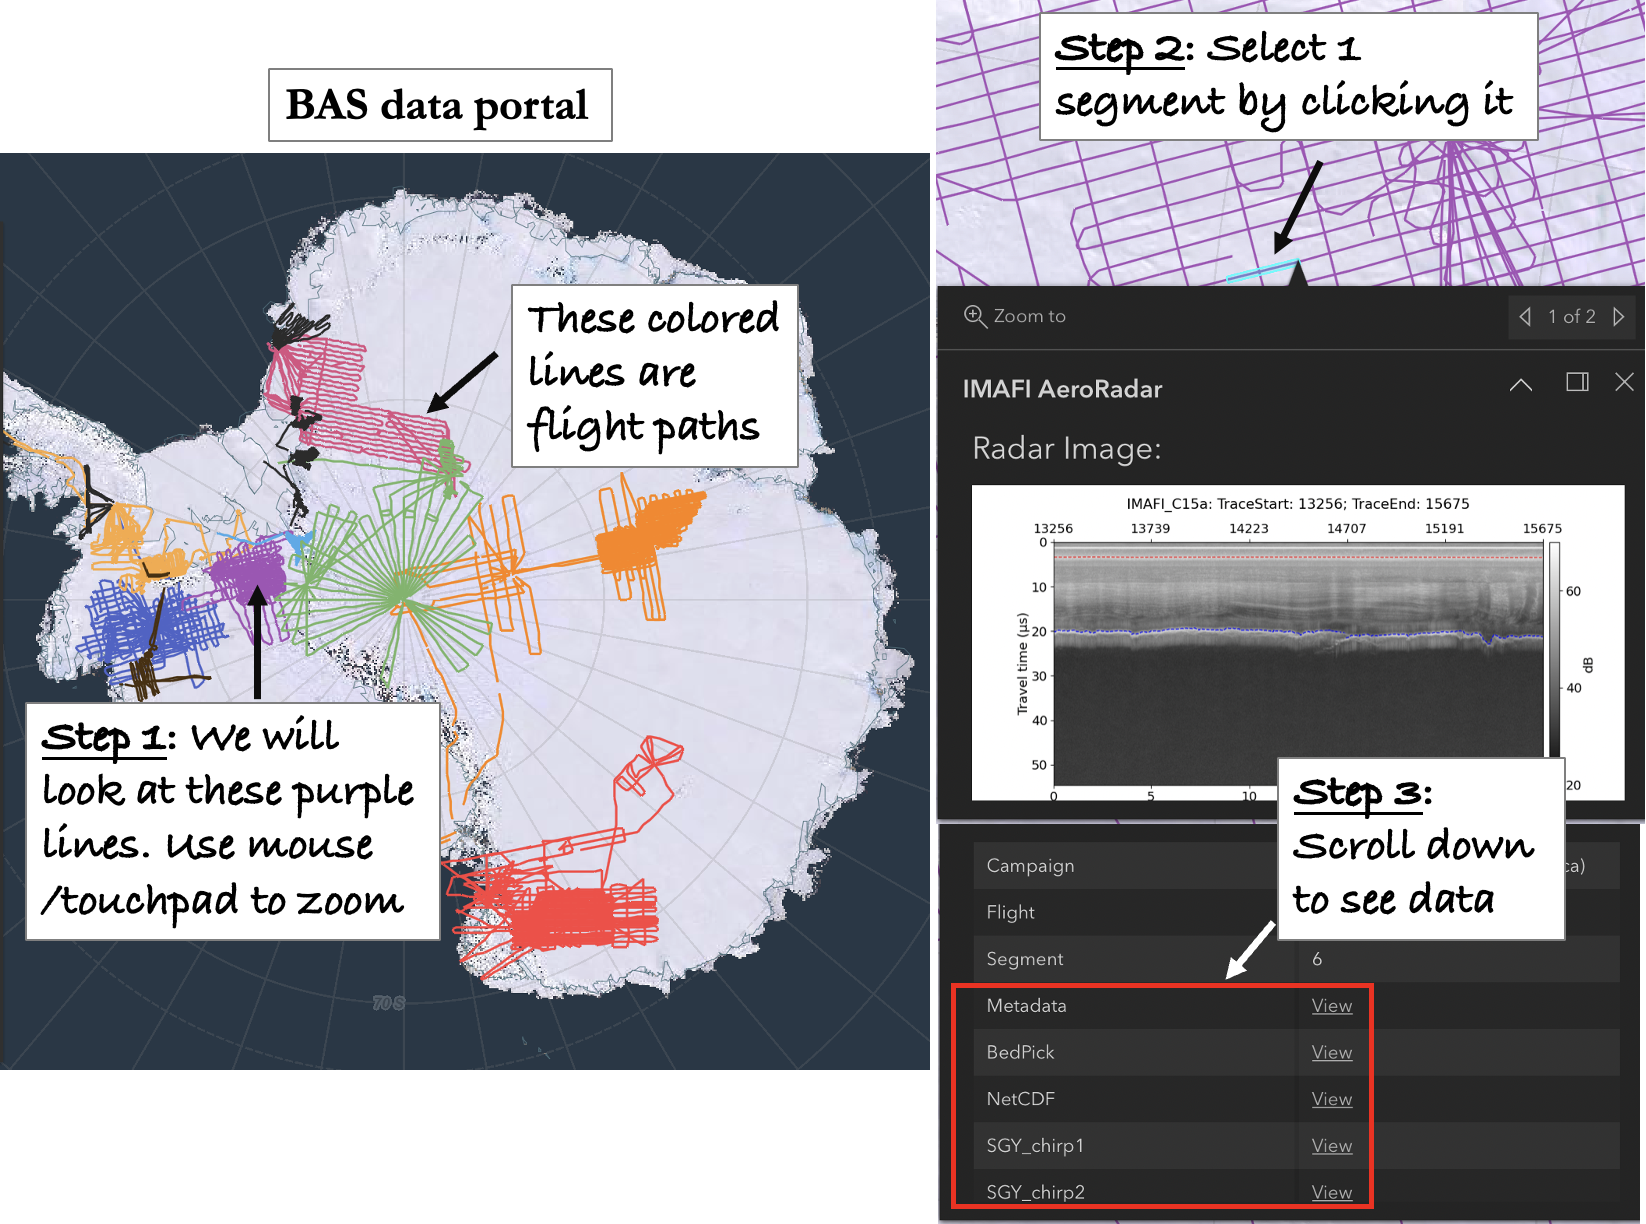

In [10]:
Image(filename="/content/GP258_radar_project/Data_intro.png", width=800, height=750)

## 4.2 Simple example to load and plot C17c segment

The data we use here are stored in .nc files.

I have downloaded the relevant data files and put them in the shared Google folder. You should have access to it. Let me know if you don't.

You can directly load the data from the shared folder. See Section 2 for instructions on how to mount your Google drive.

In [ ]:
Image(filename="/content/GP258_radar_project/IMAFI_C17c_AeroRadar_segment6.png",width=450, height=250)

### 4.2.1 Load C17c data

Access the data set of trace C17c. The following cell is my own Google drive. <u>You need to run the second cell below to load the data from your shared folder.</u> (I can't see the shared folder cause I'm the owner)

In [12]:
fp='/content/drive/MyDrive/stanford/glacier/field_data/BAS_data/Institute/data/IMAFI_C17c.nc'
nc = netCDF4.Dataset(fp)

Read relevant data. To see the full list of what data they have, go to the very end of the colab "Useful data attributes".

In [15]:
chirp_cHG= nc['chirp_cHG_data']; pulse_data= nc['pulse_data']
print(chirp_cHG)
chirp_cGH = chirp_cHG[:,:]; pulse_data = pulse_data[:,:]

x= nc['x_coordinates']; x=x[:]
y= nc['y_coordinates']; y=y[:]

<class 'netCDF4._netCDF4.Variable'>
float32 chirp_cHG_data(fast_time, traces)
    long_name: Radar data for the processed (coherent) SAR-chirp
    short_name: cHG
    units: Power in decibel-milliwatts (dBm)
unlimited dimensions: 
current shape = (1400, 23482)
filling off


### 4.2.2 First view of chirp_cHG and pulse

The chirp_cHG and pulse are shown in 2D contour, x direction is along track, y direction is depth, color is the magnitude of chirp_cHG and pulse.

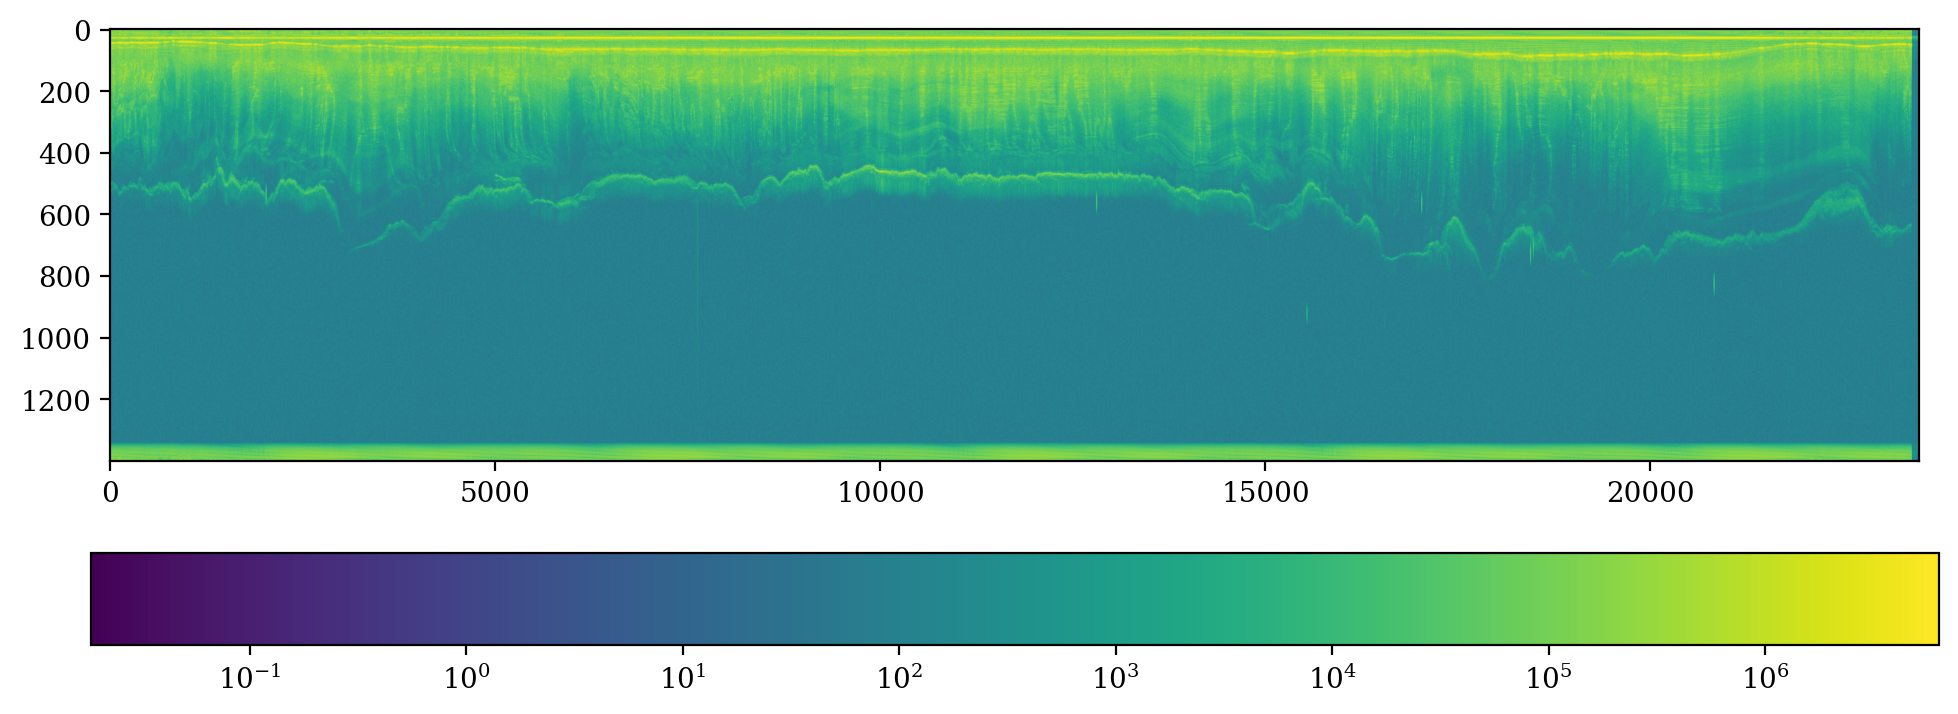

In [16]:
fig, ax = plt.subplots(figsize=(16,4))
cs = ax.imshow(chirp_cHG,norm=LogNorm(), aspect=4)
cbar = fig.colorbar(cs, orientation = 'horizontal')
cbar.ax.minorticks_off()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
cs = ax.imshow(pulse_data,norm=LogNorm(), aspect=4)
cbar = fig.colorbar(cs, orientation = 'horizontal')
cbar.ax.minorticks_off()
plt.show()

### 4.2.3 cHG and pulse along depth at one location

Here I randomly ploted the chirp_cGH and pulse signal (y axis) along the depth (x axis) at column # 100.

In [ ]:
fig, ax = plt.subplots()
plt.plot(chirp_cGH[:,100])
plt.yscale("log")
plt.show()

In [ ]:
fig, ax = plt.subplots()
plt.plot(pulse_data[:,100])
plt.yscale("log")
plt.show()

# 5 .Radar system

This info canbe found by clicking any purple lines in the data portal website, then select Metadata. It will take you to the raw data website, scroll down to see the intro on radar system. See section 4.1 for details. I pasted relevant texts below.

** Accuracy:

- Line spacing: 7.5 km
- Trace spacing (post-processed data): ~10 m
- Vertical resolution: ~8.4 m
- Radar centre frequency: 150 MHz
- Radar bandwidth: 12 MHz
- Radar Receiver vertical sampling frequency: 22 MHz
- Absolute GPS positional accuracy: ~0.1 m (relative accuracy is one order of magnitude better). Banking angle was limited to 10 degrees during aircraft turns to avoid phase issues between GPS receiver and transmitter.

** Instrumentation and Processing:

Radar data were collected using the bistatic PASIN radar echo sounding system mounted on the BAS Twin Otter aircraft "Bravo Lima" and operating with a centre frequency of 150 MHz and using two interleaved pulses: a 4-microseconds, 12 MHz bandwidth linear chirp (deep sounding) and a 0.1-microseconds unmodulated pulse (shallow sounding).

Chirp compression was applied using a Blackman window to minimise sidelobe levels, resulting in a processing gain of 10 dB. For the SAR data, 2-D Synthetic Aperture Radar (SAR) processing based on the Omega-K algorithm was applied to the data to enhance both along-track resolution and echo signal noise (see Heliere et al., 2007). The coherent SAR-chirp data (cHG) was processed using an coherent averaging filter along a moving window of length 250. The incoherent SAR-chirp data (DLRsar) was processed using an incoherent averaging filter along a moving window of length 9. Both cHG and DLRsar chirp products are complimentary and are best suited to assess the bed and internals in deep ice conditions. The coherent pulse-data was processed using a coherent averaging filter along a moving window of length 33. This data is best used to assess the internal structure and bed in shallow ice conditions.

The bed reflector was first automatically depicted on the chirp data using a semi-automatic picker in the PROMAX software package. All the picks were afterwards checked and corrected by hand if necessary. The picked travel time was then converted to depth using a radar wave speed of 168 m/microseconds and a constant firn correction of 10 m. Surface elevation is derived from radar altimeter for ground clearance < 750 m, and the PASIN system for higher altitudes.

## 5.1 Coherent (cHG) and incoherent (DLRsar) SAR-chirp data

Data description: https://data.bas.ac.uk/full-record.php?id=GB/NERC/BAS/PDC/00937

I copied relevant info below.

The BAS PASIN radar operates at a centre frequency of 150 MHz (Corr et al., 2007). The system transmits interleaved pulse and CHIRP waveforms, the former designed to resolve near-surface internal layering, and the latter for imaging of bed topography in areas of thick ice. The data described here were processed from the CHIRP dataset alone. The CHIRP has a bandwidth of 10 MHz, 4 kW of transmit power, an effective pulse repetition frequency of 312.5 Hz and a receiver sampling frequency of 22 Hz. Further detailed information describing the PASIN system can be found in Corr et al., (2007). Positioning of the aircraft was by differential GPS instruments on the aircraft, processed relative to a GPS base station at the field camp.

Data processing and analysis of the IMAFI RES data is described in detail in Ross et al., (2012) and Jeofry et al., (2018). Raw RES data were processed using Doppler processing (Hélière et al., 2007) to migrate radar-scattering hyperbola in the along-track direction, and then sampled at 13 Hz to produce along-track measurements ('traces') at ~10 m spacing. SEG-Y files of these data were produced, and imported into ProMAX, where semi-automatic picking of the ice-bed interface was undertaken by a single operator. The range from the aircraft to the ice surface was determined using the aircraft radar altimeter, or where the radar altimeter data was of poor quality, nadir LiDAR measurements. Ice thickness (in metres) was determined by multiplying the two-way travel-time between the picked ice surface and ice sheet bed by 0.168 m ns-1, and applying an approximately 10 m correction for the firn layer (Ross et al., 2012). Values of ice surface and bed elevation were then calculated relative to the WGS84 ellipsoid. The spatial reference system was WGS84 EPSG4326.


## **5.N Summary**

* Radar system
 - Bistatic Polarimetric radar Airborne Science Instrument (PASIN) radar echo sounding system
 - Center frequency: 150 MHz
 - Radar bandwidth: 12 MHz
 - Radar Receiver vertical sampling frequency: 22 MHz

* Signals
 - 2 interleaved pulses:
    - a. deep sounding: 4 ms, 12 MHz bandwidth linear chirp;
    - b. shallow sounding: 0.1 ms
 - Chirp compression: Blackman window, processing gain 10 dB
  - Coherent SAR-chirp data (cHG)
    - Coherent averaging filter, moving window of length 250
    - Bandwidth: 10 MHz
    - Transmit power: 4 kW
    - Pulse repetition freq: 312.5 Hz
    - receiver sampling freq: 22 Hz
  - Incoherent SAR-chirp data (DLRsar)
    - Incoherent averaging filter, moving window of length 9
    - Bandwidth: 10 MHz
    - Transmit power: 4 kW
    - Pulse repetition freq: 312.5 Hz
    - receiver sampling freq: 22 Hz
  - Coherent pulse
    - Coherent averaging filter, moving window of length 33

cHG and DLRsar → better for deep ice

pulse → better for shallow ice

# 6 .Select a loop

Here, we fisrt select by eyeballing, then we load the relavant dataset from google drive.

## Load all data

In [ ]:
fp='/content/drive/MyDrive/stanford/glacier/field_data/BAS_data/Institute/data/IMAFI_C09b.nc'
nc_9b = netCDF4.Dataset(fp)

fp='/content/drive/MyDrive/stanford/glacier/field_data/BAS_data/Institute/data/IMAFI_C12a.nc'
nc_12a = netCDF4.Dataset(fp)

fp='/content/drive/MyDrive/stanford/glacier/field_data/BAS_data/Institute/data/IMAFI_C17b.nc'
nc_17b = netCDF4.Dataset(fp)

fp='/content/drive/MyDrive/stanford/glacier/field_data/BAS_data/Institute/data/IMAFI_C22b.nc'
nc_22b = netCDF4.Dataset(fp)

In [ ]:
fp='/content/drive/Shareddrives/GP Project/radar_project/data/IMAFI_C09b.nc'
nc_9b = netCDF4.Dataset(fp)

fp='/content/drive/Shareddrives/GP Project/radar_project/data/IMAFI_C12a.nc'
nc_12a = netCDF4.Dataset(fp)

fp='/content/drive/Shareddrives/GP Project/radar_project/data/IMAFI_C17b.nc'
nc_17b = netCDF4.Dataset(fp)

fp='/content/drive/Shareddrives/GP Project/radar_project/data/IMAFI_C22b.nc'
nc_22b = netCDF4.Dataset(fp)

## Spatial location of flight lines

In [ ]:
x= nc_9b['x_coordinates']; x_9=x[:]
y= nc_9b['y_coordinates']; y_9=y[:]
x= nc_12a['x_coordinates']; x_12=x[:]
y= nc_12a['y_coordinates']; y_12=y[:]
x= nc_17b['x_coordinates']; x_17=x[:]
y= nc_17b['y_coordinates']; y_17=y[:]; surface_pick_layerData

In [ ]:
ice_thick = nc_9b['land_ice_thickness_layerData']; ice_thick=ice_thick[:]

In [ ]:
plt.plot(ice_thick)

In [ ]:
nc_9b

First just plot the all of the selected fligh paths.

In [ ]:
fig=plt.figure(figsize = [8,8])
ax=plt.subplot(1,1,1)
plt.plot(x_9,y_9)
plt.plot(x_12,y_12)
plt.plot(x_17,y_17)
plt.axis('equal')
plt.xlabel('x, m');plt.ylabel('y, m')
plt.legend(('C09b','C12a','C17b'))
plt.show()

## Manually select specific index to form a closed loop

In [ ]:
x_9_sq    =  x_9[45562:48512];  y_9_sq   =  y_9[45562:48512]
x_12_sq   = x_12[14072:17005]; y_12_sq   = y_12[14072:17005]
x_17_u_sq = x_17[5878 :8782 ]; y_17_u_sq = y_17[5878 :8782 ]
x_17_l_sq = x_17[34491:36768]; y_17_l_sq = y_17[34491:36768]

In [ ]:
fig=plt.figure(figsize = [8,8])
ax=plt.subplot(1,1,1)
plt.plot(x_9_sq,y_9_sq,'-')
plt.plot(x_12_sq,y_12_sq,'-')
plt.plot(x_17_u_sq,y_17_u_sq,'-')
plt.plot(x_17_l_sq,y_17_l_sq,'-')
plt.axis('equal')
plt.xlabel('x, m');plt.ylabel('y, m')
plt.legend(('C09b','C12a','C17b_u','C17b_l'))

# plt.xlim([-754250, -754100]); plt.ylim([111500, 111700]) # upper right cornor
# plt.xlim([-777900, -777700]); plt.ylim([105300, 105450]) # upper left cornor
# plt.xlim([-770450, -770250]); plt.ylim([76950, 77150]) # lower left cornor
# plt.xlim([-746900, -746700]); plt.ylim([83078, 83200]) # lower right cornor
plt.show()

## Load chirp, pulse, TWT along loop

Now that we have the selected close loop, let's extrace the data along these lines

In [ ]:
# chirp coherent
chirp_co = nc_9b['chirp_cHG_data'];  chirp_co_9=chirp_co[:,:]
chirp_co = nc_12a['chirp_cHG_data']; chirp_co_12=chirp_co[:,:]
chirp_co = nc_17b['chirp_cHG_data']; chirp_co_17=chirp_co[:,:]

# chirp incoherent
chirp_inco = nc_9b['chirp_DLRsar_data'];  chirp_inco_9=chirp_inco[:,:]
chirp_inco = nc_12a['chirp_DLRsar_data']; chirp_inco_12=chirp_inco[:,:]
chirp_inco = nc_17b['chirp_DLRsar_data']; chirp_inco_17=chirp_inco[:,:]

# pulse
pulse_data = nc_9b['pulse_data'];  pulse_data_9=pulse_data[:,:]
pulse_data = nc_12a['pulse_data']; pulse_data_12=pulse_data[:,:]
pulse_data = nc_17b['pulse_data']; pulse_data_17=pulse_data[:,:]

# two way travel time - y axis
TWT = nc_9b['fast_time']; TWT_9=TWT[:]
TWT = nc_12a['fast_time']; TWT_12a=TWT[:]
TWT = nc_17b['fast_time']; TWT_17b=TWT[:]

# traces? x axis
traces = nc_9b['traces']; traces_9=traces[:]
traces = nc_12a['traces']; traces_12=traces[:]
traces = nc_17b['traces']; traces_17=traces[:]

# crop into the loop
chirp_co_data_9  =  chirp_co_9[:,45562:48512];  chirp_co_data_9 = chirp_co_data_9.data
chirp_co_data_12 =  chirp_co_12[:,14072:17005]; chirp_co_data_12 = chirp_co_data_12.data
chirp_co_data_17_u = chirp_co_17[:,5878 :8782 ]; chirp_co_data_17_u = np.flip(chirp_co_data_17_u.data,axis=1)
chirp_co_data_17_l = chirp_co_17[:,34500:36765]; chirp_co_data_17_l = np.flip(chirp_co_data_17_l.data,axis=1)

chirp_inco_data_9  =  chirp_inco_9[:,45562:48512];  chirp_inco_data_9 = chirp_inco_data_9.data
chirp_inco_data_12 =  chirp_inco_12[:,14072:17005]; chirp_inco_data_12 = chirp_inco_data_12.data
chirp_inco_data_17_u = chirp_inco_17[:,5878 :8782 ]; chirp_inco_data_17_u = np.flip(chirp_inco_data_17_u.data,axis=1)
chirp_inco_data_17_l = chirp_inco_17[:,34500:36765]; chirp_inco_data_17_l = np.flip(chirp_inco_data_17_l.data,axis=1)

pulse_data_9   =  pulse_data_9[:,45562:48512]; pulse_data_9 = pulse_data_9.data
pulse_data_12  = pulse_data_12[:,14072:17005]; pulse_data_12 = pulse_data_12.data
pulse_data_17_u = pulse_data_17[:,5878 :8782]; pulse_data_17_u = np.flip(pulse_data_17_u.data,axis=1)
pulse_data_17_l = pulse_data_17[:,34500:36765]; pulse_data_17_l = np.flip(pulse_data_17_l.data,axis=1)

traces_9 = traces_9[45562:48512]; traces_9 = traces_9.data
traces_12 = traces_12[14072:17005]; traces_12 = traces_12.data
traces_17_u = traces_17[5878 :8782 ];traces_17_u = np.flip(traces_17_u.data)
traces_17_l = traces_17[34500:36765];traces_17_l = np.flip(traces_17_l.data)

In [ ]:
pulse_data_all=np.concatenate((pulse_data_9,pulse_data_17_u,pulse_data_12,
                           pulse_data_17_l),axis=1)
chirp_co_data_all=np.concatenate((chirp_co_data_9,chirp_co_data_17_u,chirp_co_data_12,
                               chirp_co_data_17_l),axis=1)
chirp_inco_data_all=np.concatenate((chirp_inco_data_9,chirp_inco_data_17_u,chirp_inco_data_12,
                               chirp_inco_data_17_l),axis=1)

traces = np.concatenate((traces_9,traces_17_u,traces_12,traces_17_l))


connecting_points = [48512-45562,
                     17005-14072+48512-45562-15,
                     8782-5878+17005-14072+48512-45562];

In [ ]:
print(chirp_co_data_9.shape)
print(chirp_co_data_17_u.shape)
print(chirp_co_data_12.shape)
print(chirp_co_data_17_l.shape)

In [ ]:
np.savez_compressed('/content/drive/Shareddrives/GP Project/radar_project/all_data.npz', pulse_data_all = pulse_data_all, chirp_co_data_all = chirp_co_data_all, chirp_inco_data_all = chirp_inco_data_all, traces = traces, connecting_points = connecting_points)
np.savez_compressed('/content/drive/Shareddrives/GP Project/radar_project/all_data_sections.npz', chirp_co_data_9 = chirp_co_data_9, chirp_co_data_12 = chirp_co_data_12, chirp_co_data_17_u = chirp_co_data_17_u, chirp_co_data_17_l = chirp_co_data_17_l, chirp_inco_data_9 = chirp_inco_data_9, chirp_inco_data_12 = chirp_inco_data_12, chirp_inco_data_17_u = chirp_inco_data_17_u, chirp_inco_data_17_l = chirp_inco_data_17_l)

## Plot data along the closed loop

This is data matrix contour

In [ ]:
# fig=plt.figure(figsize = [10,20])
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_all,norm=LogNorm(), aspect=0.75)
# im_ratio = chirp_co_data_all.shape[1]/chirp_co_data_all.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
for xc in connecting_points:
  plt.axvline(x = xc, color = 'w',alpha=0.2)
plt.xlabel('Along flow index');plt.ylabel('Depth index');#plt.title('Coherent Chirp')
# cbar.ax.minorticks_off()


In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_all,norm=LogNorm(), aspect=0.75)
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
for xc in connecting_points:
  plt.axvline(x = xc, color = 'w',alpha=0.2)
plt.xlabel('Along flow index');plt.ylabel('Depth index');#plt.title('Incoherent Chirp')
# cbar.ax.minorticks_off()

In [ ]:
np.savez_compressed('/content/drive/Shareddrives/GP Project/radar_project/all_data.npz', chirp_inco_data_all = chirp_inco_data_all, chirp_co_data_all = chirp_co_data_all)

This is the TWT and X contour

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = plt.contourf(np.flip(chirp_co_data_all,axis=0),norm=LogNorm())

## Plot data on each edge

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9,norm=LogNorm(), aspect=0.5)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C09')
# cbar.ax.minorticks_off()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u,norm=LogNorm(), aspect=0.5)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C17b_u')
# cbar.ax.minorticks_off()

In [ ]:
np.savez_compressed('/content/drive/Shareddrives/GP Project/radar_project/example_chirp_co_data_ver_2.npz', data_select = chirp_co_data_17_u)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_12,norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_12.shape[1]/chirp_co_data_12.shape[0]
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C12a')
cbar.ax.minorticks_off()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12,norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_12.shape[0]
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Incoherent SAR-chirp,C12a')
cbar.ax.minorticks_off()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l,norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_l.shape[1]/chirp_co_data_17_l.shape[0]
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C17b_l')
cbar.ax.minorticks_off()

In [ ]:
data_select = chirp_co_data_17_l

np.savez_compressed('/content/drive/Shareddrives/GP Project/radar_project/example_sliced_co_data_ver_2.npz', data_select = data_select)

# Handpick bed

## Coherent chirp

We can see the bed should be around depth index 700 to 800. So we select the index of the maximum received power between 700 and 800.



In [ ]:
fig, ax = plt.subplots()
plt.plot(np.linspace(700,800,num=100),chirp_co_data_9[700:800,7])
plt.xlabel('Depth index');plt.ylabel('Coherent chirp')
plt.grid()
plt.show()

### C09

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9,norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C09')
cbar.ax.minorticks_off()

#### Part 1: 1:500

X index: [1:500,700:800]

In [ ]:
x_lim_1 = 0; x_lim_2 = 500; x_extend = x_lim_2-x_lim_1
y_lim_up = 700; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 1:500, y index 700:800')
# cbar.ax.minorticks_off()
plt.show()

In [ ]:
bed_idx_c9_1 = np.zeros(x_extend)
search_area = (chirp_co_data_9[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c9_1[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c9_1[bed_idx_c9_1<740]=np.nan
plt.plot(bed_idx_c9_1)

In [ ]:
df_bed_idx_c9_1 = pd.DataFrame(bed_idx_c9_1)
# df_bed_idx_c9_1[260:280]

Hand set the nan

In [ ]:
nan_idx = [7,8,17,18,33,36,37,45,46,47,48,50,51,52,53,54,55,56,64,66,67,72,138,141,143,145,164,172,
           269,271,274]
bed_idx_c9_1[nan_idx]=np.nan

Check if delete all the blurry points

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_1-y_lim_up,color='r',alpha=0.6)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 1:500, y index 700:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 82, 50)

In [ ]:
# Save data to drive, to do local processing.

data_select = chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]

np.savez_compressed('/content/drive/Shareddrives/GP Project/radar_project/example_sliced_co_data.npz', data_select = data_select)

#### Part 2: 500:1500
X index: [500:1500,700:800]

In [ ]:
x_lim_1 = 500; x_lim_2 = 1500; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 800

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 500:1500, y index 600:800')
# cbar.ax.minorticks_off()
plt.show()

In [ ]:
chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]

In [ ]:
bed_idx_c9_2 = np.zeros(x_extend)
search_area = (chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c9_2[i] = np.argmax(search_area[:,i])+y_lim_up
# bed_idx_c9_1[bed_idx_c9_1<740]=np.nan
plt.plot(bed_idx_c9_2)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_2-y_lim_up,color='r',alpha=0.6)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 500:1500, y index 600:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 150, 100)

#### Part 3: 1500:2000

In [ ]:
x_lim_1 = 1500; x_lim_2 = 2000; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 800

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 1500:2000, y index 600:800')
# cbar.ax.minorticks_off()
plt.show()

In [ ]:
bed_idx_c9_3 = np.zeros(x_extend)
search_area = (chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c9_3[i] = np.argmax(search_area[:,i])+y_lim_up
# bed_idx_c9_1[bed_idx_c9_1<740]=np.nan
plt.plot(bed_idx_c9_3)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_3-y_lim_up,color='r',alpha=0.6)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 1500:2000, y index 600:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 100, 30)

#### Part 4: 2000:2950

In [ ]:
x_lim_1 = 2000; x_lim_2 = 2951; x_extend = x_lim_2-x_lim_1-1
y_lim_up = 530; y_lim_dow = 700

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 2000:2950, y index 600:800')
# cbar.ax.minorticks_off()
plt.show()

In [ ]:
bed_idx_c9_4 = np.zeros(x_extend)
search_area = (chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c9_4[i] = np.argmax(search_area[:,i])+y_lim_up
# bed_idx_c9_1[bed_idx_c9_1<740]=np.nan
plt.plot(bed_idx_c9_4)

In [ ]:
df_bed_idx_c9_4 = pd.DataFrame(bed_idx_c9_4)
# df_bed_idx_c9_4[830:850]

In [ ]:
nan_idx = [29,30,31,32,33]
bed_idx_c9_4[nan_idx]=[612,613,614,615,616]
nan_idx = [832]
bed_idx_c9_4[nan_idx]=[615]

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_4-y_lim_up,color='r',alpha=0.6)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 2000:2950, y index 500:700')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 100, 80)

#### Combine bed index and final picked bed

In [ ]:
bed_idx_c9=np.concatenate((bed_idx_c9_1,bed_idx_c9_2,bed_idx_c9_3,bed_idx_c9_4))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_9,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_co_data_9,1)),bed_idx_c9,color='r',alpha=0.6)
im_ratio = chirp_co_data_9.shape[1]/chirp_co_data_9.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, with bed pick')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_9[525:825,:]), 790 - 520, 650 - 520)

In [ ]:
## Try to select ice layer (may require too much memory)

irows, icols = find_shortest_path(np.log10(chirp_co_data_9[415:825,:]), 580 - 415, 480 - 415, mask_trace_low = irows - 20 + 110)

### C17 upper side

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u,norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C17 upper side')
cbar.ax.minorticks_off()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_u[500:825,:]), 605 - 500, 680 - 500)

#### Part 1: 1:750

In [ ]:
x_lim_1 = 0; x_lim_2 = 750; x_extend = x_lim_2-x_lim_1
y_lim_up = 500; y_lim_dow = 700

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C17 upper size, x index 1:750, y index 500:700')
plt.show()

In [ ]:
bed_idx_c17u_1 = np.zeros(x_extend)
search_area = (chirp_co_data_17_u[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c17u_1[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c17u_1)

In [ ]:
df_bed_idx_c17u_1 = pd.DataFrame(bed_idx_c17u_1)
# df_bed_idx_c17u_1[200:220]

In [ ]:
nan_idx = [218]
bed_idx_c17u_1[nan_idx]=624

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_1-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C17 upper size, x index 1:750, y index 500:700')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 105, 150)

#### Part 2: 750:2000

In [ ]:
x_lim_1 = 750; x_lim_2 = 2000; x_extend = x_lim_2-x_lim_1
y_lim_up = 500; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 upper side, x index 750:2000, y index 500:800')
plt.show()

In [ ]:
bed_idx_c17u_2 = np.zeros(x_extend)
search_area = (chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17u_2[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c17u_2)

In [ ]:
df_bed_idx_c17u_2 = pd.DataFrame(bed_idx_c17u_2)
df_bed_idx_c17u_2[1230:1260]

In [ ]:
nan_idx = [7,12,499,500,501,502,503,540,577,616,1032,1033,1034,1195,1218,1219,1221,1222,1223,1224,1225,
           1226,1227,1228,1229,1233,1235,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249]
bed_idx_c17u_2[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C17 upper side, x index 750:2000, y index 500:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 150, 270)

#### Part 3: 2000:2904

In [ ]:
x_lim_1 = 2000; x_lim_2 = 2904; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 900

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 upper side, x index 750:2000, y index 600:900')
plt.show()

In [ ]:
bed_idx_c17u_3 = np.zeros(x_extend)
search_area = (chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17u_3[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c17u_3[bed_idx_c17u_3>800]=np.nan
bed_idx_c17u_3[bed_idx_c17u_3<700]=np.nan
plt.plot(bed_idx_c17u_3)

In [ ]:
df_bed_idx_c17u_3 = pd.DataFrame(bed_idx_c17u_3)
# df_bed_idx_c17u_3[780:800]

In [ ]:
# nan_idx = [45,46,47,49,66,73,78,109,112,113,125,126,127,149,150,162,197,199,204,216,224,225,
#            251,252,253,255,258]
nan_idx = np.arange(40,260)
bed_idx_c17u_3[nan_idx]=np.nan
nan_idx = [319,413,417,429,430,431,442,790,793,794,796]
bed_idx_c17u_3[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_3-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C17 upper side, x index 750:2000, y index 600:900')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 160, 90)

#### Combine bed index and final picked bed

In [ ]:
bed_idx_c17u=np.concatenate((bed_idx_c17u_1,bed_idx_c17u_2,bed_idx_c17u_3))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_co_data_17_u,1)),bed_idx_c17u,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C17 upper side, with bed pick')
plt.show()

### C17 lower side

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l,norm=LogNorm(), aspect=0.75)
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C17 lower side')
cbar.ax.minorticks_off()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_l[450:800, :]), 750 - 450, 795 - 450)

#### Part 1: 1:800

In [ ]:
x_lim_1 = 0; x_lim_2 = 800; x_extend = x_lim_2-x_lim_1
y_lim_up = 550; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower size, x index 1:800, y index 550:800')
plt.show()

In [ ]:
bed_idx_c17l_1 = np.zeros(x_extend)
search_area = (chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17l_1[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c17l_1)

In [ ]:
df_bed_idx_c17l_1 = pd.DataFrame(bed_idx_c17l_1)
# df_bed_idx_c17l_1[320:360]

In [ ]:
nan_idx = [281,282,297,299,300,337,339,340,341]
bed_idx_c17l_1[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17l_1-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower size, x index 1:800, y index 550:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 200, 85)

#### Part 2: 800:1800

In [ ]:
x_lim_1 = 800; x_lim_2 = 1800; x_extend = x_lim_2-x_lim_1
y_lim_up = 500; y_lim_dow = 750

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower size, x index 800:1800, y index 500:750')
plt.show()

In [ ]:
bed_idx_c17l_2 = np.zeros(x_extend)
search_area = (chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17l_2[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c17l_2[bed_idx_c17l_2<525]=np.nan
plt.plot(bed_idx_c17l_2)

In [ ]:
df_bed_idx_c17l_2 = pd.DataFrame(bed_idx_c17l_2)
# df_bed_idx_c17l_2[20:70]

In [ ]:
nan_idx = [22,52,53,54,56,57,58,59,60,61,62,63,64,65,66,67,69,618]
bed_idx_c17l_2[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17l_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower size, x index 800:1800, y index 500:750')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 150, 120)

#### Part 3: 1800:2265

In [ ]:
x_lim_1 = 1800; x_lim_2 = 2265; x_extend = x_lim_2-x_lim_1
y_lim_up = 550; y_lim_dow = 830

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower size, x index 1800:2265, y index 550:830')
plt.show()

In [ ]:
bed_idx_c17l_3 = np.zeros(x_extend)
search_area = (chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17l_3[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c17l_3[bed_idx_c17l_3<600]=np.nan
plt.plot(bed_idx_c17l_3)

In [ ]:
df_bed_idx_c17l_3 = pd.DataFrame(bed_idx_c17l_3)
# df_bed_idx_c17l_3[120:170]

In [ ]:
nan_idx = [132,145,181,182,183,184,191,192,193,194,195,200,201]
bed_idx_c17l_3[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17l_3-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower size, x index 1800:2265, y index 550:830')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 75, 230)

#### Combine bed index and final picked bed

In [ ]:
bed_idx_c17l=np.concatenate((bed_idx_c17l_1,bed_idx_c17l_2,bed_idx_c17l_3))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_l,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_co_data_17_l,1)),bed_idx_c17l,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 lower side, with bed pick')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_17_l[450:800, :]), 750 - 450, 790 - 450)

### C12

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_12,norm=LogNorm(), aspect=0.75)
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Coherent SAR-chirp,C12')
cbar.ax.minorticks_off()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_12[575:825, :]), 700 - 575, 735 - 575)

In [ ]:
## Try to pick ice layer (may require too much memory)

irows, icols = find_shortest_path(np.log10(chirp_co_data_12[450:825, :]), 550 - 450, 600 - 450, mask_trace_low = irows - 25 + 125)

#### Part 1: 1:2933

In [ ]:
x_lim_1 = 0; x_lim_2 = 2933; x_extend = x_lim_2-x_lim_1
y_lim_up = 560; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C12, x index 1:2933, y index 560:800')
plt.show()

In [ ]:
bed_idx_c12 = np.zeros(x_extend)
search_area = (chirp_co_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c12[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c12[bed_idx_c12<590]=np.nan
plt.plot(bed_idx_c12)
plt.grid()

In [ ]:
df_bed_idx_c12 = pd.DataFrame(bed_idx_c12)
# df_bed_idx_c12[1175:1200]

In [ ]:
nan_idx = [15,109,110,111,112,119,126,129,130,153,154,157,158,159,176,177,178,179,180,185,189,
           214,291,292,293,294,295,296,300,301,302,305,306,313,314,321,340,341,342,346,347,348,349,
           350,351,352,353,354,355,356,357,358,359,360,369,370,394,395,397,398,409,411,427,444,452,453,
           455,458,459,460,465,466,467,468,469,480,481,482,547,561,562,1172,1178,1180,1181,1185,1188,
           1189,1191,1192,1194,1197,1201,1657,1665,1668,1670,1672,1679,1780,2444]
bed_idx_c12[nan_idx]=np.nan


In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c12-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp,C09, x index 1:800, y index 550:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_co_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 100, 200)

### Combine all bed picks

In [ ]:
bed_co_idx = np.concatenate((bed_idx_c9,bed_idx_c17u,bed_idx_c12,bed_idx_c17l))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_all,norm=LogNorm(), aspect=0.75)
plt.plot(bed_co_idx,color='r',alpha=1.0,linewidth=1.0)
im_ratio = chirp_co_data_all.shape[1]/chirp_co_data_all.shape[0]
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
for xc in connecting_points:
  plt.axvline(x = xc, color = 'w',alpha=0.2)
plt.xlabel('Along flow index');plt.ylabel('Depth index');#plt.title('Coherent chirp, bed pick')
# cbar.ax.minorticks_off()

## Incoherent chirp

### C09

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9,norm=LogNorm(), aspect=0.75)
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');plt.title('Inoherent SAR-chirp, C09')
cbar.ax.minorticks_off()

#### Part 1: 1:2000

In [ ]:
x_lim_1 = 0; x_lim_2 = 2000; x_extend = x_lim_2-x_lim_1
y_lim_up = 590; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C09, x index 1:2000, y index 590:800')
plt.show()

In [ ]:
bed_idx_c9_1 = np.zeros(x_extend)
search_area = (chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c9_1[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c9_1)

In [ ]:
df_bed_idx_c9_1 = pd.DataFrame(bed_idx_c9_1)
# df_bed_idx_c9_1[240:250]

In [ ]:
bed_idx_c9_1[np.arange(0,40)]=np.nan
nan_idx = [40,41,42,43,44,47,48,49,50,244,251,252,253,259]
bed_idx_c9_1[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_1-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C09, x index 1:800, y index 590:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 165, 20)

#### Part 2: 2000:2200

In [ ]:
x_lim_1 = 2000; x_lim_2 = 2200; x_extend = x_lim_2-x_lim_1
y_lim_up = 550; y_lim_dow = 700

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C09, x index 2000:2200, y index 550:700')
plt.show()

In [ ]:
bed_idx_c9_2 = np.zeros(x_extend)
search_area = (chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c9_2[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c9_2)

In [ ]:
df_bed_idx_c9_2 = pd.DataFrame(bed_idx_c9_1)
# df_bed_idx_c9_2[240:250]

In [ ]:
bed_idx_c9_1[np.arange(0,40)]=np.nan
nan_idx = [40,41,42,43,44,47,48,49,50,244,251,252,253,259]
bed_idx_c9_1[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C09, x index 2000:2200, y index 550:700')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 80, 40)

#### Part 3: 2200:2950

In [ ]:
x_lim_1 = 2200; x_lim_2 = 2950; x_extend = x_lim_2-x_lim_1
y_lim_up = 510; y_lim_dow = 700

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C09, x index 2200:2950, y index 510:700')
plt.show()

In [ ]:
bed_idx_c9_3 = np.zeros(x_extend)
search_area = (chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c9_3[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c9_3)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c9_3-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C09, x index 2000:2200, y index 550:700')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_9[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 70, 90)

#### Combine bed index and final picked bed

In [ ]:
bed_inco_idx_c9=np.concatenate((bed_idx_c9_1,bed_idx_c9_2,bed_idx_c9_3))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_9,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_inco_data_9,1)),bed_inco_idx_c9,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C09, with bed pick')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_9[515:815,:]), 790 - 515, 610 - 515)

### C17 upper side

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u,norm=LogNorm(), aspect=0.75)
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side')
cbar.ax.minorticks_off()

#### Part 1: 1:1150

In [ ]:
x_lim_1 = 0; x_lim_2 = 1150; x_extend = x_lim_2-x_lim_1
y_lim_up = 500; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 1:1150, y index 500:800')
plt.show()

In [ ]:
bed_idx_c17u_1 = np.zeros(x_extend)
search_area = (chirp_inco_data_17_u[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c17u_1[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c17u_1)

In [ ]:
df_bed_idx_c17u_1 = pd.DataFrame(bed_idx_c17u_1)
# df_bed_idx_c17u_1[200:220]

In [ ]:
nan_idx = [218]
bed_idx_c17u_1[nan_idx]=624

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_1-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 1:1150, y index 500:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 100, 140)

#### Part 2: 1150:2200

In [ ]:
x_lim_1 = 1150; x_lim_2 = 2200; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 1150:2200, y index 600:800')
plt.show()

In [ ]:
bed_idx_c17u_2 = np.zeros(x_extend)
search_area = (chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17u_2[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c17u_2)
plt.grid()

In [ ]:
df_bed_idx_c17u_2 = pd.DataFrame(bed_idx_c17u_2)
# df_bed_idx_c17u_2[830:840]

In [ ]:
nan_idx = np.arange(890,1050)
bed_idx_c17u_2[nan_idx]=np.nan
nan_idx=[852,863,877]
bed_idx_c17u_2[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 1150:2200, y index 600:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 48, 170)

#### Part 3: 2200:2904

In [ ]:
x_lim_1 = 2200; x_lim_2 = 2904; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 850

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 2200:2904, y index 600:850')
plt.show()

In [ ]:
bed_idx_c17u_3 = np.zeros(x_extend)
search_area = (chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17u_3[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c17u_3[bed_idx_c17u_3<700]=np.nan
plt.plot(bed_idx_c17u_3)
plt.grid()

In [ ]:
df_bed_idx_c17u_3 = pd.DataFrame(bed_idx_c17u_3)
# df_bed_idx_c17u_3[210:220]

In [ ]:
nan_idx=[3,5,6,8,9,15,16,17,18,19,20,21,22,29,36,37,38,44,45,48,61,64,69,75,109,120,122,123,131,213,218]
bed_idx_c17u_3[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_3-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 2200:2904, y index 600:850')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 200, 100)

#### Combine bed index and final picked bed

In [ ]:
bed_inco_idx_c17u=np.concatenate((bed_idx_c17u_1,bed_idx_c17u_2,bed_idx_c17u_3))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_inco_data_17_u,1)),bed_inco_idx_c17u,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, with bed pick')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_u[500:825,:]), 600 - 500, 700 - 500)

### C17 lower side

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_l,norm=LogNorm(), aspect=0.75)
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 lower side')
cbar.ax.minorticks_off()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_l[525:815,:]), 760 - 525, 800 - 525)

#### Part 1: 1:600

In [ ]:
x_lim_1 = 0; x_lim_2 = 600; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 lower side, x index 1:600, y index 600:800')
plt.show()

In [ ]:
bed_idx_c17l_1 = np.zeros(x_extend)
search_area = (chirp_inco_data_17_l[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c17l_1[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c17l_1[bed_idx_c17l_1<640]=np.nan
plt.plot(bed_idx_c17l_1)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17l_1-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 lower side, x index 1:60, y index 500:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 160, 40)

#### Part 2: 600:2265

In [ ]:
x_lim_1 = 600; x_lim_2 = 2265; x_extend = x_lim_2-x_lim_1
y_lim_up = 500; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 lower side, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
bed_idx_c17l_2 = np.zeros(x_extend)
search_area = (chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17l_2[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c17l_2[bed_idx_c17l_2<530]=np.nan
plt.plot(bed_idx_c17l_2)
plt.grid()

In [ ]:
plt.plot(bed_idx_c17l_2[1600:])
plt.grid()

In [ ]:
df_bed_idx_c17l_2 = pd.DataFrame(bed_idx_c17l_2)
# df_bed_idx_c17l_2[1650:1660]

In [ ]:
nan_idx=[219,220,225,227,261,264,267,269,270,272,274,275,276,277,278,279,281,283,284,285,286,287,288,289,290,294,297,
         1339,1341,1366,1367,1373,1378,1379,1380,1383,1386,1387,1389,1391,1392,1393,1394,1395,1397,1403,1406,1408,1410,
         1652,1653]
bed_idx_c17l_2[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17l_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 lower side, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_l[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 130, 285)

#### Combine bed index and final picked bed

In [ ]:
bed_inco_idx_c17l=np.concatenate((bed_idx_c17l_1,bed_idx_c17l_2))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_l,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_inco_data_17_l,1)),bed_inco_idx_c17l,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 lower side, with bed pick')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_l[525:815, :]), 760 - 525, 795 - 525)

### C12

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12,norm=LogNorm(), aspect=0.75)
cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12')
cbar.ax.minorticks_off()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[575:815,:]), 685 - 575, 760 - 575)

#### Part 1: 1:100

In [ ]:
x_lim_1 = 0; x_lim_2 = 100; x_extend = x_lim_2-x_lim_1
y_lim_up = 570; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
bed_idx_c12_1 = np.zeros(x_extend)
search_area = (chirp_inco_data_12[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c12_1[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c12_1[bed_idx_c12_1<620]=np.nan
bed_idx_c12_1[bed_idx_c12_1>680]=np.nan
plt.plot(bed_idx_c12_1)

In [ ]:
plt.plot(bed_idx_c12_1[100:200])
plt.grid()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c12_1-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 105, 78)

#### Part 2: 100:600

In [ ]:
x_lim_1 = 100; x_lim_2 = 600; x_extend = x_lim_2-x_lim_1
y_lim_up = 570; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
bed_idx_c12_2 = np.zeros(x_extend)
search_area = (chirp_inco_data_12[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c12_2[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c12_2[bed_idx_c12_2<620]=np.nan
bed_idx_c12_2[bed_idx_c12_2>660]=np.nan
plt.plot(bed_idx_c12_2)

In [ ]:
plt.plot(bed_idx_c12_1[100:200])
plt.grid()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c12_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 75, 50)

#### Part 3: 600:1600

In [ ]:
x_lim_1 = 600; x_lim_2 = 1600; x_extend = x_lim_2-x_lim_1
y_lim_up = 570; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
bed_idx_c12_3 = np.zeros(x_extend)
search_area = (chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c12_3[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c12_3[bed_idx_c12_3<590]=np.nan
bed_idx_c12_3[bed_idx_c12_3>660]=np.nan
plt.plot(bed_idx_c12_3)

In [ ]:
plt.plot(bed_idx_c12_3[550:650])
plt.grid()

In [ ]:
df_bed_idx_c12_3 = pd.DataFrame(bed_idx_c12_3)
# df_bed_idx_c12_3[590:600]

In [ ]:
nan_idx=[574,579,583,585,591]
bed_idx_c12_3[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c12_3-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 55, 90)

#### Part 4: 1600:2933

In [ ]:
x_lim_1 = 1600; x_lim_2 = 2933; x_extend = x_lim_2-x_lim_1
y_lim_up = 620; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
bed_idx_c12_4 = np.zeros(x_extend)
search_area = (chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c12_4[i] = np.argmax(search_area[:,i])+y_lim_up
# bed_idx_c12_3[bed_idx_c12_3<590]=np.nan
bed_idx_c12_4[bed_idx_c12_4>750]=np.nan
plt.plot(bed_idx_c12_4)

In [ ]:
plt.plot(bed_idx_c12_4[200:300])
plt.grid()

In [ ]:
df_bed_idx_c12_4 = pd.DataFrame(bed_idx_c12_4)
# df_bed_idx_c12_4[260:280]

In [ ]:
nan_idx=[70,74,76,78,81,120,123,126,127,129,138,139,142,240,242,261,263,266,268]
bed_idx_c12_4[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c12_4-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 45, 125)

#### Combine bed index and final picked bed

In [ ]:
bed_inco_idx_c12=np.concatenate((bed_idx_c12_1,bed_idx_c12_2,bed_idx_c12_3,bed_idx_c12_4))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12,norm=LogNorm(), aspect=0.75)
plt.plot(range(np.size(chirp_inco_data_12,1)),bed_inco_idx_c12,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, with bed pick')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[575:815,:]), 680 - 575, 765 - 575)

### Combine all bed picks

In [ ]:
bed_inco_idx = np.concatenate((bed_inco_idx_c9,bed_inco_idx_c17u,bed_inco_idx_c12,bed_inco_idx_c17l))

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_all,norm=LogNorm(), aspect=0.75)
plt.plot(bed_inco_idx,color='r',alpha=1.0,linewidth=1.0)
# cbar = fig.colorbar(cs, orientation = 'horizontal', fraction=0.05, pad=0.1)
for xc in connecting_points:
  plt.axvline(x = xc, color = 'w',alpha=0.2)
plt.xlabel('Along flow index');plt.ylabel('Depth index');#plt.title('Incoherent chirp, bed pick')
# cbar.ax.minorticks_off()

## Compare coherent and incoherent bed pick

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(bed_co_idx,linewidth=0.6)
plt.plot(bed_inco_idx,linewidth=0.6)
plt.legend(('coherent','incoherent'),loc='lower left')
plt.xlabel('Along flow index');plt.ylabel('Depth index')

# Shortest path for internal layers

## C17 upper

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u,norm=LogNorm(), aspect=0.75)
ax.add_patch(Rectangle((x_lim_1,y_lim_up), x_extend,y_extend,edgecolor='red',facecolor='none',lw=4))
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side')

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u,norm=LogNorm(), aspect=0.75)
ax.add_patch(Rectangle((x_lim_1,y_lim_up), x_extend,y_extend,edgecolor='red',facecolor='none',lw=4))
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side')

### P1: 700:1300, 300:500

In [ ]:
x_lim_1 = 700; x_lim_2 = 1300; x_extend = x_lim_2-x_lim_1;y_extend = y_lim_dow-y_lim_up
y_lim_up = 300; y_lim_dow = 500

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
x_lim_1 = 700; x_lim_2 = 1300; x_extend = x_lim_2-x_lim_1
y_lim_up = 300; y_lim_dow = 500

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_co_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Coherent SAR-chirp, C17 upper side, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
start_idx = 103
end_idx = 156
# ind_slice = [400, 815]

irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]),
                                                      start_idx, end_idx,
                                                      ind_slice = np.arange(90, 170),
                                                      mask_trace_high = )


## Ian

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import cvxpy as cp
from scipy.spatial import cKDTree

## Replace this with the correct loading script... E.g.,

# z = np.load('D:/Projects/Radar/all_data_sections.npz')

# co1, co2, co3, co4 = z['chirp_co_data_9'], z['chirp_co_data_17_u'], z['chirp_co_data_12'], z['chirp_co_data_17_l']
# inco1, inco2, inco3, inco4 = z['chirp_inco_data_9'], z['chirp_inco_data_17_u'], z['chirp_inco_data_12'], z['chirp_inco_data_17_l']

co1 = np.copy(chirp_co_data_9)
co2 = np.copy(chirp_co_data_17_u)
co3 = np.copy(chirp_co_data_12)
co4 = np.copy(chirp_co_data_17_l)

inco1 = np.copy(chirp_inco_data_9)
inco2 = np.copy(chirp_inco_data_17_u)
inco3 = np.copy(chirp_inco_data_12)
inco4 = np.copy(chirp_inco_data_17_l)

ind_edges_coh = [783, 608, 692, 751, 783]
ind_edges_incoh = [780, 607, 685, 754, 783]

ind_slice = [400, 815]

## [1]. A major ice layer

run_major_layer = False
if run_major_layer == True:

  ## Coherent
  irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co1), ind_edges_coh[0], ind_edges_coh[1], ind_slice = np.arange(ind_slice[0], ind_slice[1]), title = 'Coherent (Trace 1)')

  mask_high = np.ones(co1.shape[1]).astype('int')
  mask_high[0:1250] = 500
  mask_high[1250::] = -1

  irows_coh2, icols_coh2, fig_coh2 = find_shortest_path(np.log10(co1), 540, 457, mask_trace_high = mask_high, mask_trace_low = irows_coh1 - 30, ind_slice = np.arange(380, 800), weight_horizontals = 0.5, title = 'Coherent (Trace 1) [Major Ice Layer]', save = True)

  # np.savez_compressed('D:/Projects/Radar/example_ice_layer_coh1.npz', co1 = co1, irows_coh1 = irows_coh1, irows_coh2 = irows_coh2, icols_coh1 = icols_coh1, icols_coh2 = icols_coh2)


  ## Incoherent
  irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco1), ind_edges_incoh[0], ind_edges_incoh[1], ind_slice = np.arange(ind_slice[0], ind_slice[1]), title = 'Incoherent (Trace 1)')

  mask_high = np.ones(inco1.shape[1]).astype('int')
  mask_high[0:1250] = 500
  mask_high[1250::] = -1

  irows_incoh2, icols_incoh2, fig_incoh2 = find_shortest_path(np.log10(inco1), 540, 457, mask_trace_high = mask_high, mask_trace_low = irows_incoh1 - 30, ind_slice = np.arange(380, 800), weight_horizontals = 0.5, title = 'Incoherent (Trace 1) [Major Ice Layer]', save = True)

  # np.savez_compressed('D:/Projects/Radar/example_ice_layer_incoh1.npz', inco1 = inco1, irows_coh1 = irows_incoh1, irows_coh2 = irows_incoh2, icols_coh1 = icols_incoh1, icols_coh2 = icols_incoh2)


## [2]. A prominent thin layer

## Coherent
ind_slice = np.arange(333, 450)
ind_slice_horiz = np.arange(179, 1597) # 335
zoom = [[153, 1634], [502, 300]]
irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co2), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 2) [Thin Ice Layer]', zoom = zoom, save = False)

## Incoherent
ind_slice = np.arange(333, 450)
ind_slice_horiz = np.arange(179, 1597) # 335
zoom = [[153, 1634], [502, 300]]
irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco2), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 2) [Thin Ice Layer]', zoom = zoom, save = False)

## [3]. A curvy thin layer (not complete yet)

# ind_slice = np.arange(333, 450)
# ind_slice_horiz = np.arange(179, 1597) # 335
# zoom = [[153, 1634], [502, 300]]
# irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co4), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [Curvy Thin Ice Layer]', zoom = zoom, save = False)


# ind_slice = np.arange(333, 450)
# ind_slice_horiz = np.arange(179, 1597) # 335
# zoom = [[153, 1634], [502, 300]]
# irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco4), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [Curvy Thin Ice Layer]', zoom = zoom, save = False)


## Ian updated

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import cvxpy as cp
from scipy.spatial import cKDTree

# z = np.load('D:/Projects/Radar/all_data_sections.npz')

co1, co2, co3, co4 = z['chirp_co_data_9'], z['chirp_co_data_17_u'], z['chirp_co_data_12'], z['chirp_co_data_17_l']
inco1, inco2, inco3, inco4 = z['chirp_inco_data_9'], z['chirp_inco_data_17_u'], z['chirp_inco_data_12'], z['chirp_inco_data_17_l']

In [ ]:
ind_edges_coh = [783, 608, 692, 751, 783]
ind_edges_incoh = [780, 607, 685, 754, 783]

ind_slice = [400, 815]


# np.savez_compressed('D:/Projects/Radar/example_ice_layer_incoh1.npz', inco1 = inco1, irows_coh1 = irows_incoh1, irows_coh2 = irows_incoh2, icols_coh1 = icols_incoh1, icols_coh2 = icols_incoh2)


## [1] Major layer

In [ ]:
## [1]. A major ice layer

## Coherent
irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co1), ind_edges_coh[0], ind_edges_coh[1], ind_slice = np.arange(ind_slice[0], ind_slice[1]), title = 'Coherent (Trace 1)')

mask_high = np.ones(co1.shape[1]).astype('int')
mask_high[0:1250] = 500
mask_high[1250::] = -1

irows_coh2, icols_coh2, fig_coh2 = find_shortest_path(np.log10(co1), 540, 457, mask_trace_high = mask_high, mask_trace_low = irows_coh1 - 30, ind_slice = np.arange(380, 800), weight_horizontals = 0.5, title = 'Coherent (Trace 1) [Major Ice Layer]', save = True)

# np.savez_compressed('D:/Projects/Radar/example_ice_layer_coh1.npz', co1 = co1, irows_coh1 = irows_coh1, irows_coh2 = irows_coh2, icols_coh1 = icols_coh1, icols_coh2 = icols_coh2)


## Incoherent
irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco1), ind_edges_incoh[0], ind_edges_incoh[1], ind_slice = np.arange(ind_slice[0], ind_slice[1]), title = 'Incoherent (Trace 1)')

mask_high = np.ones(inco1.shape[1]).astype('int')
mask_high[0:1250] = 500
mask_high[1250::] = -1

irows_incoh2, icols_incoh2, fig_incoh2 = find_shortest_path(np.log10(inco1), 540, 457, mask_trace_high = mask_high, mask_trace_low = irows_incoh1 - 30, ind_slice = np.arange(380, 800), weight_horizontals = 0.5, title = 'Incoherent (Trace 1) [Major Ice Layer]', save = True)


In [ ]:
## [2]. A prominent thin layer

ind_slice = np.arange(333, 450)
ind_slice_horiz = np.arange(179, 1597) # 335
zoom = [[153, 1634], [502, 300]]
irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co2), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 2) [Thin Ice Layer]', zoom = zoom, save = True)


ind_slice = np.arange(333, 450)
ind_slice_horiz = np.arange(179, 1597) # 335
zoom = [[153, 1634], [502, 300]]
irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco2), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 2) [Thin Ice Layer]', zoom = zoom, save = True)



# ## [3]. A curvy thin layer.

# ind_slice = np.arange(333, 450)
# ind_slice_horiz = np.arange(179, 1597) # 335
# zoom = [[153, 1634], [502, 300]]
# irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co4), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [Curvy Thin Ice Layer]', zoom = zoom, save = True)


# ind_slice = np.arange(333, 450)
# ind_slice_horiz = np.arange(179, 1597) # 335
# zoom = [[153, 1634], [502, 300]]
# irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco4), 351, 443, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [Curvy Thin Ice Layer]', zoom = zoom, save = True)




# [6 extra]. Extended layers.

# Coherent
ind_slice = np.arange(245, 422)
ind_slice_horiz = np.arange(215, 765) # 335
zoom = [[152.55, 785], [450.23, 220]]
mid_point = [[372, 354], [364, 362], [360, 427], [irows_coh1[-1], icols_coh1[-1]], [280, 695]]
irows_coh1_extend, icols_coh1_extend, fig_coh1_extend = find_shortest_path(np.log10(co4), 413, 261, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [(i) Extended Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(245, 422)
ind_slice_horiz = np.arange(215, 765) # 335
zoom = [[152.55, 785], [450.23, 220]]
mid_point = [[362, 307], [irows_coh2[-1], icols_coh2[-1]]]
irows_coh2_extend, icols_coh2_extend, fig_coh2_extend = find_shortest_path(np.log10(co4), 394, 255, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [(ii) Extended Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(245, 435)
ind_slice_horiz = np.arange(224, 765) # 335
zoom = [[152.55, 785], [450.23, 220]]
mid_point = [[416, 308], [414, 347], [387, 372], [388, 442], [irows_coh3[-1], icols_coh3[-1]], [335, 599], [308, 673], [295, 719]]
irows_coh3_extend, icols_coh3_extend, fig_coh3_extend = find_shortest_path(np.log10(co4), 431, 282, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.8, title = 'Coherent (Trace 4) [(iii) Extended Steeply Dipping Layer]', zoom = zoom, save = True)


# Incoherent
ind_slice = np.arange(245, 422)
ind_slice_horiz = np.arange(215, 765) # 335
zoom = [[152.55, 785], [450.23, 220]]
mid_point = [[372, 354], [364, 362], [360, 427], [irows_incoh1[-1], icols_incoh1[-1]], [280, 695]]
irows_incoh1_extend, icols_incoh1_extend, fig_incoh1_extend = find_shortest_path(np.log10(inco4), 413, 261, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(i) Extended Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(245, 422)
ind_slice_horiz = np.arange(215, 765) # 335
zoom = [[152.55, 785], [450.23, 220]]
mid_point = [[362, 307], [irows_incoh2[-1], icols_incoh2[-1]]]
irows_incoh2_extend, icols_incoh2_extend, fig_incoh2_extend = find_shortest_path(np.log10(inco4), 394, 255, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(ii) Extended Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(245, 435)
ind_slice_horiz = np.arange(224, 765) # 335
zoom = [[152.55, 785], [450.23, 220]]
mid_point = [[416, 308], [414, 347], [387, 372], [388, 442], [irows_incoh3[-1], icols_incoh3[-1]], [335, 599], [308, 673], [295, 719]]
irows_incoh3_extend, icols_incoh3_extend, fig_incoh3_extend = find_shortest_path(np.log10(inco4), 431, 282, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.8, title = 'Incoherent (Trace 4) [(iii) Extended Steeply Dipping Layer]', zoom = zoom, save = True)



fig, ax = plt.subplots(1, figsize = [16,10])
ax.imshow(np.log10(inco4), aspect = 0.75)
ax.set_xlabel('Along flow index')
ax.set_ylabel('Depth index')
title = 'Coherent (Trace 4) [Extended Steeply Dipping Layers]'
zoom = [[152.55, 785], [450.23, 220]]
if title is not None:
	ax.set_title(title)
ax.set_ylim([940, 0])
# fig.savefig('D:/Projects/Radar/Plots/without_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	xlim_fixed, ylim_fixed = ax.get_xlim(), ax.get_ylim()
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/without_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
	ax.set_xlim(xlim_fixed)
	ax.set_ylim(ylim_fixed)
ax.scatter(icols_coh1_extend, irows_coh1_extend, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_coh2_extend, irows_coh2_extend, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_coh3_extend, irows_coh3_extend, c = 'r', s = 2, alpha = 0.5)
# fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
plt.show(block = False)


fig, ax = plt.subplots(1, figsize = [16,10])
ax.imshow(np.log10(inco4), aspect = 0.75)
ax.set_xlabel('Along flow index')
ax.set_ylabel('Depth index')
title = 'Incoherent (Trace 4) [Extended Steeply Dipping Layers]'
zoom = [[152.55, 785], [450.23, 220]]
if title is not None:
	ax.set_title(title)
ax.set_ylim([940, 0])
# fig.savefig('D:/Projects/Radar/Plots/without_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	xlim_fixed, ylim_fixed = ax.get_xlim(), ax.get_ylim()
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/without_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
	ax.set_xlim(xlim_fixed)
	ax.set_ylim(ylim_fixed)
ax.scatter(icols_incoh1_extend, irows_incoh1_extend, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_incoh2_extend, irows_incoh2_extend, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_incoh3_extend, irows_incoh3_extend, c = 'r', s = 2, alpha = 0.5)
# fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
plt.show(block = False)

### [4]. A interesting long layer.

In [ ]:
## [4]. A interesting long layer.

# (i).
ind_slice = np.arange(295, 445)
ind_slice_horiz = np.arange(1240, 1872) # 335
zoom = [[1190, 1915], [520, 250]]
irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co4), 399, 415, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [Long Thin Ice Layer]', zoom = zoom, save = True)

ind_slice = np.arange(295, 445)
ind_slice_horiz = np.arange(1240, 1872) # 335
zoom = [[1190, 1915], [485, 350]]
irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco4), 399, 415, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(i) Long Thin Ice Layer]', zoom = zoom, save = True)

# (ii).

ind_slice = np.arange(295, 445)
ind_slice_horiz = np.arange(1240, 1873) # 335
zoom = [[1190, 1915], [445, 310]]
mask_trace_high = -1*np.ones(len(ind_slice_horiz)).astype('int')
mask_trace_high[icols_coh1 - ind_slice_horiz[0]] = irows_coh1 - 45
irows_coh2, icols_coh2, fig_coh1 = find_shortest_path(np.log10(co4), 365, 377, mask_trace_high = mask_trace_high, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [(ii) Long Thin Ice Layer]', zoom = zoom, save = True)

ind_slice = np.arange(295, 445)
ind_slice_horiz = np.arange(1240, 1873) # 335
zoom = [[1190, 1915], [445, 310]]
mask_trace_high = -1*np.ones(len(ind_slice_horiz)).astype('int')
mask_trace_high[icols_incoh1 - ind_slice_horiz[0]] = irows_incoh1 - 45
irows_incoh2, icols_incoh2, fig_incoh1 = find_shortest_path(np.log10(inco4), 365, 377, mask_trace_high = mask_trace_high, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(ii) Long Thin Ice Layer]', zoom = zoom, save = True)


# (iii).

ind_slice = np.arange(295, 445)
ind_slice_horiz = np.arange(1240, 1873) # 335
zoom = [[1190, 1915], [405, 270]]
mask_trace_high = -1*np.ones(len(ind_slice_horiz)).astype('int')
mask_trace_high[icols_coh2 - ind_slice_horiz[0]] = irows_coh2 - 45
irows_coh3, icols_coh3, fig_coh1 = find_shortest_path(np.log10(co4), 327, 349, mask_trace_high = mask_trace_high, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [(iii) Long Thin Ice Layer]', zoom = zoom, save = True)

ind_slice = np.arange(295, 445)
ind_slice_horiz = np.arange(1240, 1873) # 335
zoom = [[1190, 1915], [405, 270]]
mask_trace_high = -1*np.ones(len(ind_slice_horiz)).astype('int')
mask_trace_high[icols_incoh2 - ind_slice_horiz[0]] = irows_incoh2 - 45
irows_incoh3, icols_incoh3, fig_incoh1 = find_shortest_path(np.log10(inco4), 327, 349, mask_trace_high = mask_trace_high, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(iii) Long Thin Ice Layer]', zoom = zoom, save = True)

fig, ax = plt.subplots(1, figsize = [16,10])
ax.imshow(np.log10(co4), aspect = 0.75)
ax.set_xlabel('Along flow index')
ax.set_ylabel('Depth index')
title = 'Coherent (Trace 4) [Multiple Thin Ice Layers]'
zoom = [[1188.625, 1908.310483870968], [541.1935483870968, 246.5]]
if title is not None:
	ax.set_title(title)
ax.set_ylim([960, 0])
# fig.savefig('D:/Projects/Radar/Plots/without_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	xlim_fixed, ylim_fixed = ax.get_xlim(), ax.get_ylim()
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	fig.savefig('D:/Projects/Radar/Plots/without_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
	ax.set_xlim(xlim_fixed)
	ax.set_ylim(ylim_fixed)
ax.scatter(icols_coh1, irows_coh1, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_coh2, irows_coh2, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_coh3, irows_coh3, c = 'r', s = 2, alpha = 0.5)
# fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)

fig, ax = plt.subplots(1, figsize = [16,10])
ax.imshow(np.log10(inco4), aspect = 0.75)
ax.set_xlabel('Along flow index')
ax.set_ylabel('Depth index')
title = 'Incoherent (Trace 4) [Multiple Thin Ice Layers]'
zoom = [[1188.625, 1908.310483870968], [541.1935483870968, 246.5]]
if title is not None:
	ax.set_title(title)
ax.set_ylim([960, 0])
# fig.savefig('D:/Projects/Radar/Plots/without_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	xlim_fixed, ylim_fixed = ax.get_xlim(), ax.get_ylim()
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/without_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
	ax.set_xlim(xlim_fixed)
	ax.set_ylim(ylim_fixed)
ax.scatter(icols_incoh1, irows_incoh1, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_incoh2, irows_incoh2, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_incoh3, irows_incoh3, c = 'r', s = 2, alpha = 0.5)
# fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)


### [5] An interesting layer.

In [ ]:
# [5]. An interesting layer.

ind_slice = np.arange(377, 434)
ind_slice_horiz = np.arange(650, 1080) # 335
zoom = [[594.43, 1107.07], [472.82, 345.18]]
irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co2), 407, 426, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 2) [(i) Interesting Ice Layer]', zoom = zoom, save = True)

ind_slice = np.arange(377, 434)
ind_slice_horiz = np.arange(650, 1080) # 335
zoom = [[594.43, 1107.07], [472.82, 345.18]]
irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco2), 407, 426, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 2) [(i) Interesting Ice Layer]', zoom = zoom, save = True)



### [6] A steeply dipping layer.

In [ ]:
# [6]. A steeply dipping layer.

# Coherent
ind_slice = np.arange(322, 422)
ind_slice_horiz = np.arange(215, 542) # 335
zoom = [[152.55, 576.32], [450.23, 277.31]]
mid_point = [[360, 427]]
irows_coh1, icols_coh1, fig_coh1 = find_shortest_path(np.log10(co4), 413, 334, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [(i) Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(322, 422)
ind_slice_horiz = np.arange(215, 542) # 335
zoom = [[152.55, 576.32], [450.23, 277.31]]
mid_point = [[362, 307]]
irows_coh2, icols_coh2, fig_coh2 = find_shortest_path(np.log10(co4), 394, 324, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Coherent (Trace 4) [(ii) Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(322, 435)
ind_slice_horiz = np.arange(224, 540) # 335
zoom = [[152.55, 576.32], [450.23, 277.31]]
mid_point = [[416, 308], [414, 347], [387, 372], [388, 442]]
irows_coh3, icols_coh3, fig_coh3 = find_shortest_path(np.log10(co4), 431, 358, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.8, title = 'Coherent (Trace 4) [(iii) Steeply Dipping Layer]', zoom = zoom, save = True)


# Incoherent
ind_slice = np.arange(322, 422)
ind_slice_horiz = np.arange(215, 542) # 335
zoom = [[152.55, 576.32], [450.23, 277.31]]
mid_point = [[360, 427]]
irows_incoh1, icols_incoh1, fig_incoh1 = find_shortest_path(np.log10(inco4), 413, 334, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(i) Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(322, 422)
ind_slice_horiz = np.arange(215, 542) # 335
zoom = [[152.55, 576.32], [450.23, 277.31]]
mid_point = [[362, 307]]
irows_incoh2, icols_incoh2, fig_incoh2 = find_shortest_path(np.log10(inco4), 394, 324, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.5, title = 'Incoherent (Trace 4) [(ii) Steeply Dipping Layer]', zoom = zoom, save = True)

ind_slice = np.arange(322, 435)
ind_slice_horiz = np.arange(224, 540) # 335
zoom = [[152.55, 576.32], [450.23, 277.31]]
mid_point = [[416, 308], [414, 347], [387, 372], [388, 442]]
irows_incoh3, icols_incoh3, fig_incoh3 = find_shortest_path(np.log10(inco4), 431, 358, mid_point = mid_point, ind_slice = ind_slice, ind_slice_horiz = ind_slice_horiz, weight_horizontals = 0.8, title = 'Incoherent (Trace 4) [(iii) Steeply Dipping Layer]', zoom = zoom, save = True)

fig, ax = plt.subplots(1, figsize = [16,10])
ax.imshow(np.log10(inco4), aspect = 0.75)
ax.set_xlabel('Along flow index')
ax.set_ylabel('Depth index')
title = 'Incoherent (Trace 4) [Steeply Dipping Layers]'
zoom = [[152.55, 576.32], [450.23, 277.31]]
if title is not None:
  ax.set_title(title)
# fig.savefig('D:/Projects/Radar/Plots/without_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	xlim_fixed, ylim_fixed = ax.get_xlim(), ax.get_ylim()
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/without_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
	ax.set_xlim(xlim_fixed)
	ax.set_ylim(ylim_fixed)
ax.scatter(icols_incoh1, irows_incoh1, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_incoh2, irows_incoh2, c = 'r', s = 2, alpha = 0.5)
ax.scatter(icols_incoh3, irows_incoh3, c = 'r', s = 2, alpha = 0.5)
# fig.savefig('D:/Projects/Radar/Plots/with_trace_' + title, bbox_inches = 'tight', pad_inches = 0.2)
if zoom is not None:
	ax.set_xlim(zoom[0])
	ax.set_ylim(zoom[1])
	# fig.savefig('D:/Projects/Radar/Plots/with_trace_zoom_' + title, bbox_inches = 'tight', pad_inches = 0.2)
plt.show(block = False)

-------------------
-------------------
# !!! IGNORE Anything below this section for now

# Preprocessing

## Clear up data

This steps include clear up NaNs, and filter any signal that's >700 (consider erroneous). Then construct dataframe of the bed data along radar paths that is loaded in the previous step.

In [ ]:
# shape the data type into the ones that's processed by solver
df_bed = pd.DataFrame.from_dict({'X':x,'Y':y,'Bed':bed}, orient='index')
df_bed=df_bed.transpose()
print(len(bed),len(x),len(y))
bed = bed[bed <= 700]
df_bed.head()

In [ ]:
# remove nans
df_bed.head()
df_bed = df_bed[df_bed['Bed'].isnull() == False]
df_bed.head()

## First view of data

In [ ]:
# plot utility functions
splot2D(df=df_bed, title='Subglacial topography data')

# Variogram

## Grid data to the desired simulation resolution.

Grid data to the desired simulation resolution. This is important because the resolution of the data affects the spatial statistics. We recommend gridding the data to the resolution at which you will be performing the interpolation.

In [ ]:
# grid data to 1000 m resolution
res = 1100
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)

# plot gridded bed
fig, ax = plt.subplots(1, figsize=(5,5))
im = plt.imshow(grid_matrix, cmap='gist_earth', vmin=-400, vmax=600,
                interpolation='none', origin='upper')
plt.title('Gridded topography')
plt.xlabel('X [px]'); plt.ylabel('Y [px]')

# make color bar
cbar = make_colorbar(fig, im, -400, 600, 'Bed [m]')

ax.axis('scaled')
plt.show()

Remove the nans

In [ ]:
# remove nans
df_grid = df_grid[df_grid['Z'].isnull() == False]
# df_grid.rename(columns = {'Z':'Bed'}, inplace = True)
df_grid.head()

## Compute Normal Score Transformation

Many geostatistical methods require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical analysis such as kriging, the data is back-transformed to it’s original distribution.

In [ ]:
# normal score transformation
data = df_grid['Z'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_grid['Nbed'] = nst_trans.transform(data)
# plot original bed histogram
plt.subplot(121)
plt.hist(df_grid['Z'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-2500,500]);
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)
# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_grid['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]);
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
# plot transformed data
splot2D(df=df_grid, title='Transformed bed data', c='Nbed', vmin=-3, vmax=3, s=5)

## Compute Experimental Variogram

The semivariogram, often just referred to as the variogram, is used to qauntify spatial dependence for irregularly spaced data. It computes the average variance of the difference between two data points with a given separation distance, or lag distance $h$

$\gamma_h=\dfrac{1}{2N(h)}\Sigma_{i=1}^N[z(x_i)-z(x_i+h)]^2$

where $x$ is a spatial location, $z(x_i)$ is a variable (e.g. bed elevation), and $N$ is the number of lag distances. This can become computationally expensive, so we recommend randomly downsampling for large datasets.

We’ll start by computing the isotropic variogram, which averages across different azimuthal directions using the Scikit GStat tools.

In [ ]:
# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 5e4      # maximum range distance
n_lags = 70       # num of bins

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

## Fit variogram Model

In [ ]:
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags,
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'
V1.parameters

These values are the range, sill, and nugget, respectively. The range describes the correlation length, or distance where two measurements are no longer correlated The sill is variance where the range is reached. The nugget is the variance at a lag distance of zero.

The nugget effect is often attributed to measurement error (i.e., a non-zero nugget results from measurements with different values at the same location). We have a nugget of zero because our data is gridded. Depending on the analysis, it can be useful to work with non-gridded data in order to investigate the nugget effect and measurement uncertainty. For certain interpolation problems, it is best to have a nugget of zero, while sometimes it is useful to include the nugget.

Now we will create the variogram model. While there are many different variogram model types (see SCiKit-GStat documentation), GStatSim uses the exponential variogram model, which is the most widely used:

$\gamma(h)=b+(c-b)[1-\exp(-\dfrac{3h}{a})]$

where $b$ is the nugget, $h$ is the lag distance, $c$ is the sill, and $a$ is the range. Note that the SCiKit-GStat variogram modeling defaults assign a nugget of 0.

In [ ]:
# set variogram parameters
vrange = V1.parameters[0]
vsill = V1.parameters[1]
vnugget = V1.parameters[2]

# evaluate models
xi = np.linspace(0, xdata[-1], 1000)
y_exp = [models.exponential(h, vrange, vsill, vnugget) for h in xi]

# plot variogram model
plt.figure(figsize=(6,4))
plt.plot(xdata, ydata,'og', markersize=4, label='Experimental variogram')
plt.plot(xi, y_exp,'-', label='Modeled variogram')
plt.title('Isotropic variogram')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='upper left')
plt.show()

## Initialize grid

In [ ]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)
print(df_grid)
print(len(Pred_grid_xy))

In [ ]:
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))

# Simple Kriging

Simple kriging assumes that the mean is stationary and known. The data is treated as a residual from the mean, which is computed as the average of conditioning points. Sometimes this is a good assumption, but in some cases it is not. We will apply it here to see what happens.

In [ ]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill]


k = 100         # number of neighboring data points used to estimate a given point
rad = 50000     # 50 km search radius

# est_SK is the estimate and var_SK is the variance
est_SK, var_SK = gs.Interpolation.skrige(Pred_grid_xy, df_grid, 'X', 'Y', 'Z', k, vario, rad)

In [ ]:
# reverse normal score transformation

var_SK[var_SK < 0] = 0      # make sure variances are non-negative
std_SK = np.sqrt(var_SK)    # convert to standard deviation before back transforming

# reshape
est = est_SK.reshape(-1,1)
std = std_SK.reshape(-1,1)

# back transformation
spred_trans = nst_trans.inverse_transform(est)
sstd_trans = nst_trans.inverse_transform(std)
sstd_trans = sstd_trans - np.min(sstd_trans)

In [ ]:
# plot simple kriging and standard deviation
mplot2_std(Pred_grid_xy, est, sstd_trans, rows, cols,
           title1='Simple kriging, sill=1', title2='Standard deviation')

# Sequential Gaussian simulation

In [ ]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1100
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data)

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags,
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'

In [ ]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [ ]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill]

k = 48         # number of neighboring data points used to estimate a given point
rad = 50000    # 50 km search radius

sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)

In [ ]:
# reverse normal score transformation
sim1 = sim.reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim1)
mplot2_std(Pred_grid_xy, sim_trans, sstd_trans, rows, cols,
           title1='Sequential Gaussian simulation', title2='Standard deviation')
# # mplot1(Pred_grid_xy, sim_trans, rows, cols,
# #        title='Sequential Gaussian simulation', clabel='Bed elevation [m]')
# mplot1(Pred_grid_xy, sim_trans, rows, cols,
#        title='SGS realization hillshade', hillshade=False)

# save data

In [ ]:
dict_tosave = {"x_syth": x_mat, "y_syth": y_mat,"bed_syth":sim_trans}
scipy.io.savemat('syth_bed.mat', dict_tosave)

# Useful data attributes

The example nc files can be found here: https://ramadda.data.bas.ac.uk/repository/entry/show?entryid=synth%3Af32b298b-7906-4360-9e34-16739af73bb7%3AL25ldGNkZg%3D%3D

* Each .nc file contains following parameters:

--------------------< traces >---------------------

long_name:  Trace number for the radar data (x axis)
short_name:  traceNum


--------------------< fast_time >---------------------

long_name:  Two-way travel time (y axis)

standard_name:  time

units:  microseconds


--------------------< x_coordinates >---------------------

long_name:  Cartesian x-coordinates (WGS84 EPSG:3031) for the radar data

standard_name:  projection_x_coordinate

units:  m

--------------------< y_coordinates >---------------------

long_name:  Cartesian y-coordinates (WGS84 EPSG:3031) for the radar data

standard_name:  projection_y_coordinate

units:  m

--------------------< chirp_cHG_data >---------------------

long_name:  Radar data for the processed (coherent) SAR-chirp

short_name:  cHG

units:  Power in decibel-milliwatts (dBm)

--------------------< chirp_DLRsar_data >---------------------

long_name:  Radar data for the processed (incoherent) SAR-chirp

short_name:  DLRsar

units:  Power in decibel-milliwatts (dBm)

--------------------< pulse_data >---------------------

long_name:  Radar data for the processed (coherent) pulse

units:  Power in decibel-milliwatts (dBm)


--------------------< longitude_layerData >---------------------

long_name:  Longitudinal position of the trace number (coordinate system: WGS84 EPSG:4326)

standard_name:  longitude

units:  degree_east

--------------------< latitude_layerData >---------------------

long_name:  Latitudinal position of the trace number (coordinate system: WGS84 EPSG:4326)

standard_name:  latitude

units:  degree_north

--------------------< UTC_time_layerData >---------------------

long_name:  Coordinated Universal Time (UTC) of trace

short_name:  resTime

units:  seconds

--------------------< PriNumber_layerData >---------------------

long_name:  The PRI number is an incremental integer reference number related to initialisation of the radar system that permits processed SEG-Y data and picked surface and bed to be linked back to raw radar data

short_name:  PriNum

--------------------< terrainClearanceAircraft_layerData >---------------------

_FillValue:  -9999

long_name:  Terrain clearance distance from platform to air interface with ice, sea or ground

short_name:  resHt

units:  m

--------------------< aircraft_altitude_layerData >---------------------

_FillValue:  -9999

long_name:  Aircraft altitude

short_name:  Eht

units:  m relative to WGS84 ellipsoid

--------------------< surface_altitude_layerData >---------------------

_FillValue:  -9999

long_name:  Ice surface elevation for the trace
number from radar altimeter and LiDAR

standard_name:  surface_altitude

short_name:  surfElev

units:  m relative to the WGS84 ellipsoid

--------------------< surface_pick_layerData >---------------------

_FillValue:  -9999

long_name:  Location down trace of surface pick (BAS system)

short_name:  surfPickLoc

units:  microseconds

--------------------< bed_altitude_layerData >---------------------

_FillValue:  -9999

long_name:  Bedrock elevation for the trace number derived by subtracting ice thickness from surface elevation

standard_name:  bed_altitude

short_name:  bedElev

units:  m relative to the WGS84 ellipsoid

--------------------< bed_pick_layerData >---------------------

_FillValue:  -9999

long_name:  Location down trace of bed pick (BAS system)

short_name:  botPickLoc

units:  microseconds

--------------------< land_ice_thickness_layerData >---------------------

_FillValue:  -9999

long_name:  Ice thickness for the trace number obtained by multiplying the two-way travel-time between the picked ice surface and ice sheet bed by 168 m/microseconds and applying a 10 meter correction for the firn layer

standard_name:  land_ice_thickness

short_name:  iceThick

units:  m

--------------------< trace_number_thinIcelayerData >---------------------

long_name:  Trace number for the pre-processed pulse radar data for thin ice areas (<200 m ice thickness)

short_name:  traceNum

--------------------< longitude_thinIcelayerData >---------------------

long_name:  Longitudinal position of the trace number (coordinate system: WGS84 EPSG:4326) for thin ice areas (<200 m ice thickness)

standard_name:  longitude

units:  degree_east

--------------------< latitude_thinIcelayerData >---------------------

long_name:  Latitudinal position of the trace number (coordinate system: WGS84 EPSG:4326) for thin ice areas (<200 m ice thickness)

standard_name:  latitude

units:  degree_north

--------------------< UTC_time_thinIcelayerData >---------------------

long_name:  Coordinated Universal Time (UTC) of trace for thin ice areas (<200 m ice thickness)

short_name:  resTime

units:  seconds

--------------------< PriNum_thinIcelayerData >---------------------

long_name:  The PRI number is an incremental integer reference number related to initialisation of the radar system that permits processed SEG-Y data and picked surface and bed to be linked back to raw radar data for thin ice areas (<200 m ice thickness)

short_name:  PriNum

--------------------< terrain_clearanceAircraft_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Terrain clearance distance from platform to air interface with ice, sea or ground for thin ice areas (<200 m ice thickness)

short_name:  resHt

units:  m

--------------------< aircraft_altitude_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Aircraft altitude for thin ice areas (<200 m ice thickness)

short_name:  Eht

units:  m relative to WGS84 ellipsoid

--------------------< surface_altitude_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Ice surface elevation for the trace number from radar altimeter and LiDAR for thin ice areas (<200 m ice thickness)

standard_name:  surface_altitude

short_name:  surfElev

units:  m relative to the WGS84 ellipsoid

--------------------< surface_pick_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Location down trace of bed pick (BAS system) for thin ice areas (<200 m ice thickness)

short_name:  surfPickLoc

units:  microseconds

--------------------< bed_altitude_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Bedrock elevation for the trace number derived by subtracting ice thickness from surface elevation for thin ice areas (<200 m ice thickness)

standard_name:  bed_altitude

short_name:  bedElev

units:  m relative to the WGS84 ellipsoid

--------------------< bed_pick_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Location down trace of bed pick (BAS system) for thin ice areas (<200 m ice thickness)

short_name:  botPickLoc

units:  microseconds

--------------------< land_ice_thickness_thinIcelayerData >---------------------

_FillValue:  -9999

long_name:  Ice thickness for the trace number obtained by multiplying the two-way travel-time between the picked ice surface and ice sheet bed by 168 m/microseconds and applying a 10 meter correction for the firn layer for thin ice areas (<200 m ice thickness)

standard_name:  land_ice_thickness

short_name:  iceThick

units:  m


#### Part 2: 100:600

In [ ]:
x_lim_1 = 100; x_lim_2 = 600; x_extend = x_lim_2-x_lim_1
y_lim_up = 570; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
bed_idx_c12_2 = np.zeros(x_extend)
search_area = (chirp_inco_data_12[y_lim_up:y_lim_dow,:])
for i in range (x_extend):
    bed_idx_c12_2[i] = np.argmax(search_area[:,i])+y_lim_up
bed_idx_c12_2[bed_idx_c12_2<620]=np.nan
bed_idx_c12_2[bed_idx_c12_2>660]=np.nan
plt.plot(bed_idx_c12_2)

In [ ]:
plt.plot(bed_idx_c12_1[100:200])
plt.grid()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c12_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C12, x index '+str(x_lim_1)+':'+str(x_lim_2)+', y index '+str(y_lim_up)+':'+str(y_lim_dow))
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_12[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 75, 50)

#### Part 2: 1150:2200

In [ ]:
x_lim_1 = 1150; x_lim_2 = 2200; x_extend = x_lim_2-x_lim_1
y_lim_up = 600; y_lim_dow = 800

fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
im_ratio = chirp_co_data_17_u.shape[1]/chirp_co_data_17_u.shape[0]
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp, C17 upper side, x index 1150:2200, y index 600:800')
plt.show()

In [ ]:
bed_idx_c17u_2 = np.zeros(x_extend)
search_area = (chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2])
for i in range (x_extend):
    bed_idx_c17u_2[i] = np.argmax(search_area[:,i])+y_lim_up
plt.plot(bed_idx_c17u_2)
plt.grid()

In [ ]:
df_bed_idx_c17u_2 = pd.DataFrame(bed_idx_c17u_2)
df_bed_idx_c17u_2[830:840]

In [ ]:
nan_idx = np.arange(890,1050)
bed_idx_c17u_2[nan_idx]=np.nan
nan_idx=[852,863,877]
bed_idx_c17u_2[nan_idx]=np.nan

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax=plt.subplot(1,1,1)
cs = ax.imshow(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2],norm=LogNorm(), aspect=0.75)
plt.plot(range(x_extend),bed_idx_c17u_2-y_lim_up,color='r',alpha=0.6)
plt.xlabel('Along flow index');plt.ylabel('Depth index');
plt.title('Incoherent SAR-chirp,C09, x index 1150:2200, y index 600:800')
plt.show()

In [ ]:
irows, icols = find_shortest_path(np.log10(chirp_inco_data_17_u[y_lim_up:y_lim_dow,x_lim_1:x_lim_2]), 50, 170)